# Further Feature Engineering & Baseline Modeling

In this notebook, we will take a new approach to feature engineering and ways to reduce dimensionality in the dataset, as well as explore additional model algorithms for baseline modeling.

Let's start by importing our `final_df` that we created after data cleaning but *prior* to feature engineering in the previous notebook.

In [1]:
# Import basic packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load final_df
final_df = pd.read_json('data/final_df.json', lines=True)

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49378 entries, 0 to 49377
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49378 non-null  object 
 1   title                 49378 non-null  object 
 2   actors                49378 non-null  object 
 3   directors             49378 non-null  object 
 4   genres                49378 non-null  object 
 5   language_en           49378 non-null  int64  
 6   year                  49378 non-null  int64  
 7   runtime               49378 non-null  int64  
 8   budget                17818 non-null  float64
 9   box_office_gross      21049 non-null  float64
 10  production_companies  49378 non-null  object 
 11  votes                 49378 non-null  int64  
 12  rating                49378 non-null  float64
 13  rating_category       49378 non-null  object 
 14  decade                49378 non-null  int64  
 15  review_text        

Great, we have loaded our final dataframe. Now, before we do any feature engineering, we will make some decisions about which data to drop before modeling, as we were not very aggressive with dropping outliers or other potentially noisy data.

Firstly, let's check how many of our movies have less than 5 reviews.

In [4]:
# Count the number of rows where review_count is less than 5
count = len(final_df[final_df['review_count'] < 5])

print(f"There are {count} rows where the review_count is less than 5.")

There are 11085 rows where the review_count is less than 5.


Checking the distribution across classes:

In [5]:
# Filter for movies with fewer than 5 reviews
filtered_df = final_df[final_df['review_count'] < 5]

# Count of 'rating_category' in the filtered data
class_distribution = filtered_df['rating_category'].value_counts()

print("Distribution of classes for movies with fewer than 5 reviews:")
print(class_distribution)

Distribution of classes for movies with fewer than 5 reviews:
rating_category
Average      3030
Good         3027
Poor         2696
Excellent    2332
Name: count, dtype: int64


Well, 11,000 movies is a good chunk of our dataset, but this could also help reduce noise and potentially speed up modeling time, so for now we'll go with the tradeoff. Additionally, the movies are fairly evenly split across the target variable classes, so this shouldn't introduce much bias in our final model.

In [6]:
# Filter final_df to keep only movies with 5 or more reviews
final_df = final_df[final_df['review_count'] >= 5]

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38293 entries, 0 to 49377
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               38293 non-null  object 
 1   title                 38293 non-null  object 
 2   actors                38293 non-null  object 
 3   directors             38293 non-null  object 
 4   genres                38293 non-null  object 
 5   language_en           38293 non-null  int64  
 6   year                  38293 non-null  int64  
 7   runtime               38293 non-null  int64  
 8   budget                15937 non-null  float64
 9   box_office_gross      19543 non-null  float64
 10  production_companies  38293 non-null  object 
 11  votes                 38293 non-null  int64  
 12  rating                38293 non-null  float64
 13  rating_category       38293 non-null  object 
 14  decade                38293 non-null  int64  
 15  review_text           38

We might also want to think about reducing the size of the dataset based on the number of votes per movie. Let's check to see how many movies have fewer than 100 votes for the rating.

In [8]:
# Count the number of rows where votes is less than 100
count = len(final_df[final_df['votes'] < 100])

print(f"There are {count} rows where the votes are less than 100.")

There are 98 rows where the votes are less than 100.


Only 98 rows, so not a huge loss. Let's check to see how they are distibuted across classes.

In [9]:
# Filter for movies with fewer than 100 votes
filtered_df = final_df[final_df['votes'] < 100]

# Count of 'rating_category' in the filtered data
class_distribution = filtered_df['rating_category'].value_counts()

print("Distribution of classes for movies with fewer than 100 votes:")
print(class_distribution)

Distribution of classes for movies with fewer than 100 votes:
rating_category
Average      30
Poor         30
Good         20
Excellent    18
Name: count, dtype: int64


The distribution is reasonably even, so let's go ahead and make this change, to drop rows with movies that have fewer than 100 votes for the rating.

In [10]:
# Filter final_df to keep only movies with 100 or more votes
final_df = final_df[final_df['votes'] >= 100]

In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38195 entries, 0 to 49377
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               38195 non-null  object 
 1   title                 38195 non-null  object 
 2   actors                38195 non-null  object 
 3   directors             38195 non-null  object 
 4   genres                38195 non-null  object 
 5   language_en           38195 non-null  int64  
 6   year                  38195 non-null  int64  
 7   runtime               38195 non-null  int64  
 8   budget                15924 non-null  float64
 9   box_office_gross      19536 non-null  float64
 10  production_companies  38195 non-null  object 
 11  votes                 38195 non-null  int64  
 12  rating                38195 non-null  float64
 13  rating_category       38195 non-null  object 
 14  decade                38195 non-null  int64  
 15  review_text           38

Now that we've cut down the size of our dataset, let's also reconsider how we were using the decade column. We will try a different approach this time, and use a "years since release" column instead of binning the deacdes into different categories. This should help reduce dimensionality and may capture temporal trends better.

In [12]:
from datetime import datetime

# Get the current year
current_year = datetime.now().year

# Create a new column with the years since release
final_df.loc[:, 'years_since_release'] = current_year - final_df['year']

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38195 entries, 0 to 49377
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               38195 non-null  object 
 1   title                 38195 non-null  object 
 2   actors                38195 non-null  object 
 3   directors             38195 non-null  object 
 4   genres                38195 non-null  object 
 5   language_en           38195 non-null  int64  
 6   year                  38195 non-null  int64  
 7   runtime               38195 non-null  int64  
 8   budget                15924 non-null  float64
 9   box_office_gross      19536 non-null  float64
 10  production_companies  38195 non-null  object 
 11  votes                 38195 non-null  int64  
 12  rating                38195 non-null  float64
 13  rating_category       38195 non-null  object 
 14  decade                38195 non-null  int64  
 15  review_text           38

In [14]:
final_df.head()

,imdb_id,title,actors,directors,genres,language_en,year,runtime,budget,box_office_gross,production_companies,votes,rating,rating_category,decade,review_text,review_count,years_since_release
0,tt0004972,The Birth of a Nation,"[Lillian Gish,Mae Marsh,Henry B. Walthall,Miri...",[D.W. Griffith],"[Drama, History, War]",1,1915,195,100000.0,10000000.0,[Epoch Film Co.],25782,6.2,Average,1910,unbelievable; I cannot understand how anyone c...,329,108
1,tt0023622,Trouble in Paradise,"[Miriam Hopkins,Kay Francis,Herbert Marshall,C...",[Ernst Lubitsch],"[Comedy, Crime, Romance]",1,1932,83,519706.0,1035500.0,[Paramount],15707,8.0,Excellent,1930,I'm still starry-eyed from it; I saw this last...,64,91
2,tt0118688,Batman & Robin,"[Arnold Schwarzenegger,George Clooney,Chris OD...",[Joel Schumacher],"[Action, Sci-Fi]",1,1997,125,125000000.0,107325195.0,"[DC Comics, PolyGram Filmed Entertainment, War...",263149,3.8,Poor,1990,Failed on every Front; Joel Schumacher who did...,1675,26
3,tt0346491,Alexander,"[Colin Farrell,Anthony Hopkins,Rosario Dawson,...",[Oliver Stone],"[Action, Biography, Drama]",1,2004,175,155000000.0,34297191.0,"[France 3 Cinéma, WR Universal Group, Warner B...",173996,5.6,Average,2000,"Poor Casting, Poor script Poor direction.; I h...",1399,19
4,tt0094721,Beetlejuice,"[Alec Baldwin,Geena Davis,Michael Keaton,Annie...",[Tim Burton],"[Comedy, Fantasy]",1,1988,92,15000000.0,73707461.0,"[Warner Bros. Pictures, Geffen Pictures]",321436,7.5,Excellent,1980,An Accomplished Tim Burton Movie; A Great Idea...,320,35


Great, looks like that worked as expected. At this point, let's save our reduced final dataframe again.

In [15]:
# Save final reduced df to csv
final_df.to_json('data/final_df_reduced.json', orient='records', lines=True)

Now we can drop the year and decade columns, since we won't use them for modeling. Additionally, we can also drop the title column, since we won't be using it for modeling. We'll keep the rating column for now, since we will use that for KNN Imputer when imputing the budget and box office gross information.

In [166]:
# Drop uneeded columns
final_df = final_df.drop(columns=['year', 'decade', 'title'])

In [167]:
final_df.reset_index(drop=True, inplace=True)

In [168]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38195 entries, 0 to 38194
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               38195 non-null  object 
 1   actors                38195 non-null  object 
 2   directors             38195 non-null  object 
 3   genres                38195 non-null  object 
 4   language_en           38195 non-null  int64  
 5   runtime               38195 non-null  int64  
 6   budget                15924 non-null  float64
 7   box_office_gross      19536 non-null  float64
 8   production_companies  38195 non-null  object 
 9   votes                 38195 non-null  int64  
 10  rating                38195 non-null  float64
 11  rating_category       38195 non-null  object 
 12  review_text           38195 non-null  object 
 13  review_count          38195 non-null  int64  
 14  years_since_release   38195 non-null  int64  
dtypes: float64(3), int6

#### Encoding Actors, Directors, Production Companies

Now, we'll move on to encoding the top entities for actor, director and production companies. Previously, we one hot encoded the most frequently occurring entities in movies that were rated Good or Excellent. 

This time, we'll replace each director (or actor, or production company) with a score based on their track record in order to convert those categorical variables into a useful numerical form. Hopefully this will better capture the quality associated with each entity.

**The Challenge:**
Encoding entities such as actors, directors, or production companies poses a unique set of challenges, particularly due to the high cardinality of these features. Traditional encoding techniques like one-hot encoding can lead to an explosion of dimensions, making the model complex and prone to overfitting. Furthermore, each entity's relationship with the target variable, rating in this case, is non-linear and can't be adequately captured through simple numeric representations.

**The Solution:**
To circumvent these challenges, a custom score was calculated for each entity based on a weighted score that aims to condense the influence and success of each entity into a single numeric value, allowing for more straightforward and meaningful comparisons.

Although the custom score includes information about the 'rating' from which our target variable, 'rating_category' is derived, it doesn't constitute full data leakage. The score for each entity is calculated using aggregated information from multiple rows, meaning it doesn't give away the rating of any specific movie. Essentially, the score serves as a form of target encoding, where statistics based on the target variable are used to encode categorical variables. This approach aims to capture the underlying relationship between the entity and the average movie rating without directly revealing information about any individual movie's rating.


In the function below, we accumulate a weighted sum of ratings for each entity. This sum is weighted in two ways:

- By a decay factor to give more importance to more recent movies.
- By an extra weight if the movie has a high rating (above 7).


After accumulating this weighted sum across all movies the entity is involved in, we divide it by the total number of movies the entity has been in. This gives us a weighted average rating for each entity.


To make this score even more nuanced, we multiply it by the number of times the entity has been listed either first or second in the list of entities for a movie. This aims to give additional weight to entities that are often prominent or 'featured' in the list, under the assumption that being listed first or second may indicate a significant role in the movie.


So, in summary, the custom score encapsulates:
- The average rating of all movies an entity is involved in, adjusted for both recency and high ratings.
- The entity's prominence by counting how many times it's been listed as first or second when there are at least three entities listed.
- This way, we try to get a comprehensive view of an entity's contribution and relevance in the context of movie ratings.

*Note:* Ideally, in a real world scenario, we would create a pipeline for data pre-processing, and we would complete this feature engineering after the train test split. However, due to the limited amout of data that we have for this project, we will engineer this feature on the entire dataset before the train test split.

In [169]:
from collections import defaultdict

# Define function to calculate entity score
def calculate_weighted_entity_rating(df, entity_col, rating_col, years_since_release_col):
    entity_rating_sum = defaultdict(float)
    entity_movie_count = defaultdict(int)
    entity_first_second_count = defaultdict(int)
    
    # Loop through DataFrame to populate dictionaries
    for i, row in df.iterrows():
        entities = row[entity_col]
        rating = row[rating_col]
        years_since_release = row[years_since_release_col]
        
        # Calculate time decay weight 
        decay_factor = 0.9
        weight = decay_factor ** years_since_release

        # Add extra weight for high-rated movies
        high_rating_weight = 1.5 if rating > 7 else 1.0
        weight *= high_rating_weight
        
        for idx, entity in enumerate(entities):
            # Weighted sum of ratings
            entity_rating_sum[entity] += rating * weight
            
            # Count of movies the entity has been in
            entity_movie_count[entity] += 1
            
            # Count of times the entity has been #1 or #2 in list
            if idx == 0 or idx == 1 and len(entities) >= 3:
                entity_first_second_count[entity] += 1
    
    # Calculate the score for each entity
    entity_scores = {}
    
    for entity in entity_rating_sum:
        weighted_avg_rating = entity_rating_sum[entity] / entity_movie_count[entity]
        first_second_count = entity_first_second_count[entity]
        
        entity_scores[entity] = weighted_avg_rating * first_second_count
    
    # Calculate the score for each row in DataFrame
    row_scores = []
    
    for entities in df[entity_col]:
        scores = [entity_scores.get(entity, 0) for entity in entities]
        avg_score = np.mean(scores) if scores else 0
        row_scores.append(avg_score)
        
    return pd.Series(row_scores, index=df.index)

In [170]:
# Calculate actors score 
final_df['actors_score'] = calculate_weighted_entity_rating(final_df, 'actors', 'rating', 'years_since_release')

In [171]:
# Calculate directors score
final_df['directors_score'] = calculate_weighted_entity_rating(final_df, 'directors', 'rating', 'years_since_release')

In [172]:
# Calculate producer's score
final_df['producers_score'] = calculate_weighted_entity_rating(final_df, 'production_companies', 'rating', 'years_since_release')

Now, we have an entity score for each of actors, directors, and production companies.

#### Summary 
For additional data pre-processing in this notebook we have: 
- Dropped 11k rows with less than 20 user text reviews (`reviews_count`)
- Dropped 98 rows with less than 100 user ratings (`votes`)
    - *Could* be more aggressive with both of these, but decided to make the tradeoff of losing almost 12k datapoints vs. 20k with more aggressive thresholds
- Created a `years_since_release` column to replace our previous `year` and `decade` columns 
    - Hope this will capture temporal trends related to the age of the movie 
    -  Might be more interpretable, e.g. it's easier to grasp the significance of a one-year increase in the "Years Since Release" than to interpret what moving from one "decade bin" to another means.
    - In a real-world scenario with a dynamic dataset that keeps getting updated with new movies, "Years Since Release" would automatically adjust
- Created a custom 'entity score' to numerically encode actors, directors, and production companies.

---

### Train Test Split 
Now that we have our final dataframe with concatenated review text for each movie, the next step is to complete our train test split before doing any feature engineering.

In [173]:
from sklearn.model_selection import train_test_split

# Splitting the data into 80% training and 20% testing
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

In [176]:
# Reset index
train_df.reset_index(drop=True, inplace=True)

In [177]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30556 entries, 0 to 30555
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               30556 non-null  object 
 1   actors                30556 non-null  object 
 2   directors             30556 non-null  object 
 3   genres                30556 non-null  object 
 4   language_en           30556 non-null  int64  
 5   runtime               30556 non-null  int64  
 6   budget                12764 non-null  float64
 7   box_office_gross      15678 non-null  float64
 8   production_companies  30556 non-null  object 
 9   votes                 30556 non-null  int64  
 10  rating                30556 non-null  float64
 11  rating_category       30556 non-null  object 
 12  review_text           30556 non-null  object 
 13  review_count          30556 non-null  int64  
 14  years_since_release   30556 non-null  int64  
 15  actors_score       

In [178]:
# Reset index
test_df.reset_index(drop=True, inplace=True)

In [179]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7639 entries, 0 to 7638
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               7639 non-null   object 
 1   actors                7639 non-null   object 
 2   directors             7639 non-null   object 
 3   genres                7639 non-null   object 
 4   language_en           7639 non-null   int64  
 5   runtime               7639 non-null   int64  
 6   budget                3160 non-null   float64
 7   box_office_gross      3858 non-null   float64
 8   production_companies  7639 non-null   object 
 9   votes                 7639 non-null   int64  
 10  rating                7639 non-null   float64
 11  rating_category       7639 non-null   object 
 12  review_text           7639 non-null   object 
 13  review_count          7639 non-null   int64  
 14  years_since_release   7639 non-null   int64  
 15  actors_score         

We can now drop the actors, directors, and production companies columns since we have our newly engineered scores.

In [180]:
# Drop original columns from both datasets 
train_df = train_df.drop(columns=['actors', 'directors', 'production_companies'])
test_df = test_df.drop(columns=['actors', 'directors', 'production_companies'])

In [181]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30556 entries, 0 to 30555
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_id              30556 non-null  object 
 1   genres               30556 non-null  object 
 2   language_en          30556 non-null  int64  
 3   runtime              30556 non-null  int64  
 4   budget               12764 non-null  float64
 5   box_office_gross     15678 non-null  float64
 6   votes                30556 non-null  int64  
 7   rating               30556 non-null  float64
 8   rating_category      30556 non-null  object 
 9   review_text          30556 non-null  object 
 10  review_count         30556 non-null  int64  
 11  years_since_release  30556 non-null  int64  
 12  actors_score         30556 non-null  float64
 13  directors_score      30556 non-null  float64
 14  producers_score      30556 non-null  float64
dtypes: float64(6), int64(5), object(4)
m

#### Genres 
Now let's move on to encoding our genres. We've made the decision to include all genres from the dataset, and one hot encode them  because: 
- Genres on IMDb are assigned in alphabetical order, unlike the cast and crew, which are assigned in order of credit/importance. 
- Genres, while they could be predictive of a certain rating, don't have an inherent "score" or "track record" like directors, actors, and production companies.

In [182]:
# One-hot encode genres for train_df
genres_dummies_train = train_df['genres'].str.join('|').str.get_dummies()
genres_dummies_train = genres_dummies_train.add_prefix('genre_')
train_df = pd.concat([train_df, genres_dummies_train], axis=1)

# One-hot encode genres for test_df
genres_dummies_test = test_df['genres'].str.join('|').str.get_dummies()
genres_dummies_test = genres_dummies_test.add_prefix('genre_')
test_df = pd.concat([test_df, genres_dummies_test], axis=1)

In [183]:
# Drop the original 'genres' column from train_df and test_df
train_df.drop('genres', axis=1, inplace=True)
test_df.drop('genres', axis=1, inplace=True)

In [184]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30556 entries, 0 to 30555
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_id              30556 non-null  object 
 1   language_en          30556 non-null  int64  
 2   runtime              30556 non-null  int64  
 3   budget               12764 non-null  float64
 4   box_office_gross     15678 non-null  float64
 5   votes                30556 non-null  int64  
 6   rating               30556 non-null  float64
 7   rating_category      30556 non-null  object 
 8   review_text          30556 non-null  object 
 9   review_count         30556 non-null  int64  
 10  years_since_release  30556 non-null  int64  
 11  actors_score         30556 non-null  float64
 12  directors_score      30556 non-null  float64
 13  producers_score      30556 non-null  float64
 14  genre_Action         30556 non-null  int64  
 15  genre_Adventure      30556 non-null 

In [185]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7639 entries, 0 to 7638
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_id              7639 non-null   object 
 1   language_en          7639 non-null   int64  
 2   runtime              7639 non-null   int64  
 3   budget               3160 non-null   float64
 4   box_office_gross     3858 non-null   float64
 5   votes                7639 non-null   int64  
 6   rating               7639 non-null   float64
 7   rating_category      7639 non-null   object 
 8   review_text          7639 non-null   object 
 9   review_count         7639 non-null   int64  
 10  years_since_release  7639 non-null   int64  
 11  actors_score         7639 non-null   float64
 12  directors_score      7639 non-null   float64
 13  producers_score      7639 non-null   float64
 14  genre_Action         7639 non-null   int64  
 15  genre_Adventure      7639 non-null   i

Despite doing extensive searches for missing genres in our previous cleaning and EDA steps, it seems that there are still missing genre data, and the rows are filled with N/A! Let's count the occurences in both datasets to see if it might be best to just drop them.

In [186]:
# Count the number of 'genre_N/A' in train_df
train_na_count = train_df['genre_N/A'].sum()
print(f"Number of 'genre_N/A' in train_df: {train_na_count}")

# Count the number of 'genre_N/A' in test_df
test_na_count = test_df['genre_N/A'].sum()
print(f"Number of 'genre_N/A' in test_df: {test_na_count}")

Number of 'genre_N/A' in train_df: 6
Number of 'genre_N/A' in test_df: 3


This is a small number, so we will go ahead and drop those rows from both train and test.

In [187]:
# Find index of rows where 'genre_N/A' is 1 in train_df
train_na_indexes = train_df[train_df['genre_N/A'] == 1].index

# Drop these rows
train_df.drop(train_na_indexes, inplace=True)

# Reset index 
train_df.reset_index(drop=True, inplace=True)

In [188]:
# Find the index of rows where 'genre_N/A' is 1 in test_df
test_na_indexes = test_df[test_df['genre_N/A'] == 1].index

# Drop these rows
test_df.drop(test_na_indexes, inplace=True)

# Reset index 
test_df.reset_index(drop=True, inplace=True)

In [189]:
# Check value counts before dropping column
train_df['genre_N/A'].value_counts()

genre_N/A
0    30550
Name: count, dtype: int64

In [190]:
# Check value counts before dropping column
test_df['genre_N/A'].value_counts()

genre_N/A
0    7636
Name: count, dtype: int64

In [191]:
# Drop genre_N/A column for both datasets 
train_df.drop('genre_N/A', axis=1, inplace=True)
test_df.drop('genre_N/A', axis=1, inplace=True)

In [192]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_id              30550 non-null  object 
 1   language_en          30550 non-null  int64  
 2   runtime              30550 non-null  int64  
 3   budget               12764 non-null  float64
 4   box_office_gross     15678 non-null  float64
 5   votes                30550 non-null  int64  
 6   rating               30550 non-null  float64
 7   rating_category      30550 non-null  object 
 8   review_text          30550 non-null  object 
 9   review_count         30550 non-null  int64  
 10  years_since_release  30550 non-null  int64  
 11  actors_score         30550 non-null  float64
 12  directors_score      30550 non-null  float64
 13  producers_score      30550 non-null  float64
 14  genre_Action         30550 non-null  int64  
 15  genre_Adventure      30550 non-null 

In [193]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7636 entries, 0 to 7635
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   imdb_id              7636 non-null   object 
 1   language_en          7636 non-null   int64  
 2   runtime              7636 non-null   int64  
 3   budget               3160 non-null   float64
 4   box_office_gross     3858 non-null   float64
 5   votes                7636 non-null   int64  
 6   rating               7636 non-null   float64
 7   rating_category      7636 non-null   object 
 8   review_text          7636 non-null   object 
 9   review_count         7636 non-null   int64  
 10  years_since_release  7636 non-null   int64  
 11  actors_score         7636 non-null   float64
 12  directors_score      7636 non-null   float64
 13  producers_score      7636 non-null   float64
 14  genre_Action         7636 non-null   int64  
 15  genre_Adventure      7636 non-null   i

We can see that our `train_df` has one additional column from `test_df`, which is `genre_Talk-Show`. Let's take a closer look at the value counts for this column. 

In [194]:
# Count occurrences of talk show genre
train_df['genre_Talk-Show'].value_counts()

genre_Talk-Show
0    30549
1        1
Name: count, dtype: int64

Only one positive value for this column means we should just go ahead and drop it, since it's not going to add much value to our model. Let's go ahead and look at the value counts for each of our genre columns to see which others might have extremely low counts that aren't adding much information to our data. 

In [195]:
# Loop through each column
# Print value counts if the column starts with genre_
# Filter for count less than 100 
for col in train_df.columns:
    if col.startswith('genre_'):
        value_count = train_df[col].value_counts()
        if value_count.get(1, 0) < 100:
            print(f"Value counts for {col}:")
            print(value_count)
            print("-----")

Value counts for genre_News:
genre_News
0    30526
1       24
Name: count, dtype: int64
-----
Value counts for genre_Reality-TV:
genre_Reality-TV
0    30548
1        2
Name: count, dtype: int64
-----
Value counts for genre_Talk-Show:
genre_Talk-Show
0    30549
1        1
Name: count, dtype: int64
-----


Based on these numbers, we will go and and drop Talk-Show, Reality-Tv, and News. They are all under 50 total positive values for the dataset, which is not going to add any information to our model. Additionally, these are movies, so those genres seem like they may have been added in error, or might not be as "important" as other genres. 

In [196]:
# Drop columns from both train and test. 
train_df = train_df.drop(columns=['genre_News', 'genre_Reality-TV', 'genre_Talk-Show'])
test_df = test_df.drop(columns=['genre_News', 'genre_Reality-TV'])

Great, now we should have the same columns in both datasets, and we have reduced dimensionality for columns that weren't adding any value.

In [197]:
# Checkpoint here for train_df and test_df
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

#### KNN Imputer for Budget and Gross Info 
Now that we've split our data into train and test, and one hot encoded the relevant features, we will be attempting to impute the missing values in our budget and box office gross columns using KNN imputer.

Before we implement KNN, we will need to scale our numeric features, since KNN is a distance-based algorithm.

In [198]:
from sklearn.preprocessing import StandardScaler

In [199]:
# Initialize the scaler
scaler = StandardScaler()

In [200]:
# List of columns to scale
columns_to_scale = ['runtime', 'votes', 'budget', 'box_office_gross', 'rating', 'review_count', 'years_since_release', 'directors_score', 'actors_score', 'producers_score']

In [201]:
# Make a copy of scaled dataframes 
scaled_train_df = train_df.copy()
scaled_test_df = test_df.copy()

In [202]:
# Fit and transform train
scaled_train_df[columns_to_scale] = scaler.fit_transform(scaled_train_df[columns_to_scale])

In [203]:
# Transform test
scaled_test_df[columns_to_scale] = scaler.transform(scaled_test_df[columns_to_scale])

Now that we've scaled our numeric features, we can go ahead and use k-nearest neighbors to estimate and fill in the missing values for budget and box office gross.

In [204]:
# Select only the numeric columns (excluding the text column)
numeric_cols = scaled_train_df.select_dtypes(include=['float64', 'int64']).columns

In [205]:
# Save numeric columsn 
train_numeric = scaled_train_df[numeric_cols]
test_numeric = scaled_test_df[numeric_cols]

In [206]:
# Import necessary libraries
from sklearn.impute import KNNImputer

In [207]:
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

Fit KNNImputer on our train data and then fit to the test data:

In [208]:
# Perform imputation on the numeric columns
# Fit and transform train 
train_imputed = imputer.fit_transform(train_numeric)

# Transform test
test_imputed = imputer.transform(test_numeric)

In [209]:
# Convert the results back to DataFrames
train_imputed_df = pd.DataFrame(train_imputed, columns=train_numeric.columns)
test_imputed_df = pd.DataFrame(test_imputed, columns=train_numeric.columns)

Now we need to join our imputed columns back with the original non-numeric features from our original train and test dataframes.

In [210]:
# Identify non-numeric columns in original dataframe 
non_numeric_cols_train = train_df.select_dtypes(exclude=['float64', 'int64']).columns
non_numeric_cols_test = test_df.select_dtypes(exclude=['float64', 'int64']).columns

In [211]:
# Concatenate imputed dataframe with the non-numeric columns from the original dataframe
train_final_df = pd.concat([train_imputed_df, train_df[non_numeric_cols_train]], axis=1)
test_final_df = pd.concat([test_imputed_df, test_df[non_numeric_cols_test]], axis=1)

In [212]:
# Check the shapes
print("Shape of original DataFrame:", train_df.shape)
print("Shape of imputed DataFrame:", train_imputed_df.shape)
print("Shape of final DataFrame:", train_final_df.shape)

Shape of original DataFrame: (30550, 37)
Shape of imputed DataFrame: (30550, 34)
Shape of final DataFrame: (30550, 37)


In [213]:
# Check indices align
print((train_final_df.index == train_df.index).all())
print((test_final_df.index == test_df.index).all())

True
True


In [214]:
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   language_en          30550 non-null  float64
 1   runtime              30550 non-null  float64
 2   budget               30550 non-null  float64
 3   box_office_gross     30550 non-null  float64
 4   votes                30550 non-null  float64
 5   rating               30550 non-null  float64
 6   review_count         30550 non-null  float64
 7   years_since_release  30550 non-null  float64
 8   actors_score         30550 non-null  float64
 9   directors_score      30550 non-null  float64
 10  producers_score      30550 non-null  float64
 11  genre_Action         30550 non-null  float64
 12  genre_Adventure      30550 non-null  float64
 13  genre_Animation      30550 non-null  float64
 14  genre_Biography      30550 non-null  float64
 15  genre_Comedy         30550 non-null 

It looks like everything worked as expected, and we no longer have any null values for budget and box_office_gross!

Let's move our `imdb_id` and target feature, `rating_category` to the top of the feature list for both dataframes.

In [215]:
# Get the list of all column names except 'rating_category' and 'imdb_id'
cols = [col for col in train_final_df.columns if col not in ['rating_category', 'imdb_id']]

# Reorder the columns so that 'rating_category' and 'imdb_id' are at the front
train_final_df = train_final_df[['rating_category', 'imdb_id'] + cols]

# Do the same for the test dataframe
cols_test = [col for col in test_final_df.columns if col not in ['rating_category', 'imdb_id']]
test_final_df = test_final_df[['rating_category', 'imdb_id'] + cols_test]

Now, since we're done with feature engineering, we'll go ahead and drop the rating feature, since we'll be predicting the rating category instead.

In [216]:
# Drop rating feature
train_final_df = train_final_df.drop(columns=['rating'])
test_final_df = test_final_df.drop(columns=['rating'])

In [217]:
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating_category      30550 non-null  object 
 1   imdb_id              30550 non-null  object 
 2   language_en          30550 non-null  float64
 3   runtime              30550 non-null  float64
 4   budget               30550 non-null  float64
 5   box_office_gross     30550 non-null  float64
 6   votes                30550 non-null  float64
 7   review_count         30550 non-null  float64
 8   years_since_release  30550 non-null  float64
 9   actors_score         30550 non-null  float64
 10  directors_score      30550 non-null  float64
 11  producers_score      30550 non-null  float64
 12  genre_Action         30550 non-null  float64
 13  genre_Adventure      30550 non-null  float64
 14  genre_Animation      30550 non-null  float64
 15  genre_Biography      30550 non-null 

In [218]:
test_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7636 entries, 0 to 7635
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating_category      7636 non-null   object 
 1   imdb_id              7636 non-null   object 
 2   language_en          7636 non-null   float64
 3   runtime              7636 non-null   float64
 4   budget               7636 non-null   float64
 5   box_office_gross     7636 non-null   float64
 6   votes                7636 non-null   float64
 7   review_count         7636 non-null   float64
 8   years_since_release  7636 non-null   float64
 9   actors_score         7636 non-null   float64
 10  directors_score      7636 non-null   float64
 11  producers_score      7636 non-null   float64
 12  genre_Action         7636 non-null   float64
 13  genre_Adventure      7636 non-null   float64
 14  genre_Animation      7636 non-null   float64
 15  genre_Biography      7636 non-null   f

Great! Now we should be ready for modeling with our numeric data, and the next step is to pre-process our text data. However, before we do that, it might be useful to run a baseline logistic regression model on just our numerical features to see how predictive they are of the target variable. We'll run a couple different models so we can see how much the addition of the text data later improves model performance.

### Baseline Models (Numeric Only)

In [219]:
# Import libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

We'll start with a simple Logistic Regression model.

In [221]:
X_train = train_final_df.drop(['rating_category', 'imdb_id', 'review_text'], axis=1)
y_train = train_final_df['rating_category']

X_test = test_final_df.drop(['rating_category', 'imdb_id', 'review_text'], axis=1)
y_test = test_final_df['rating_category']

# Instantiate model 
logreg = LogisticRegression(max_iter=1000)

# Fit model 
logreg.fit(X_train, y_train)

# Make predictions
train_predictions = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

# Evaluate
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.5281178396072013
Test Accuracy: 0.5331325301204819


With no hyperparater optimization, we're getting only a little better than a random guess on our model's accuracy. However, we know already that our features are not very linearlly related, so likely logistic regression won't be our best model. We can also look at the classification report to see more details of how the. model is makaing predictions.

In [222]:
# Classification report 
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to dataframe 
report_df = pd.DataFrame(report).transpose()

In [223]:
report_df

,precision,recall,f1-score,support
Average,0.424183,0.341759,0.378536,1899.000000
Excellent,0.654233,0.627128,0.640394,1762.000000
Good,0.420060,0.427273,0.423635,1980.000000
Poor,0.612151,0.737343,0.668940,1995.000000
accuracy,0.533133,0.533133,0.533133,0.533133
macro avg,0.527657,0.533376,0.527876,7636.000000
weighted avg,0.525307,0.533133,0.526525,7636.000000


We are getting the best precision and recall on the Excellent and Poor classes, while the model is having more trouble predicing Average and Good movies.

Next, we can also look at a heatmap of the confusion matrix, to determine which classes are "confusing" the model and being predicted incorrectly.

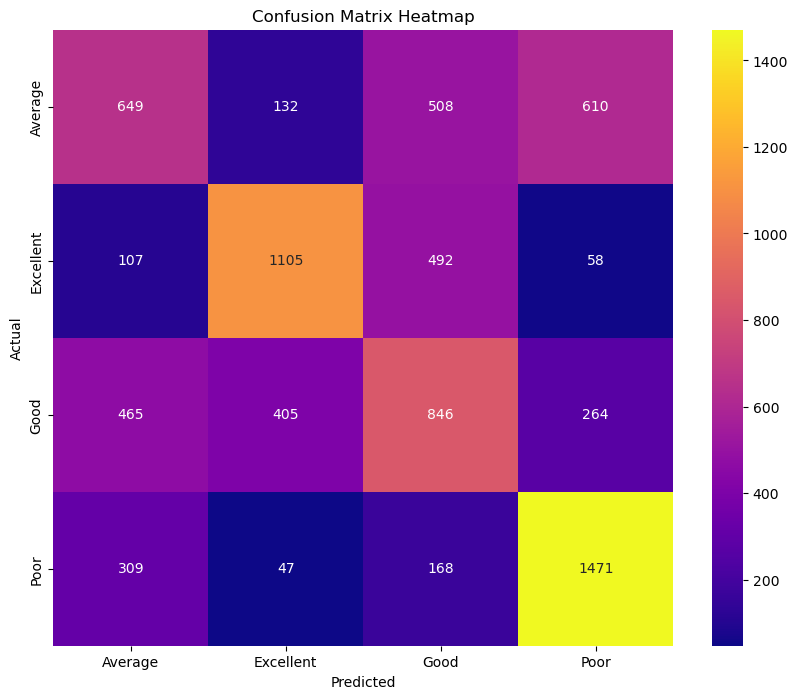

In [224]:
# Plotting heatmap of confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Class labels
class_labels = ['Average', 'Excellent', 'Good', 'Poor']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma', xticklabels=class_labels, yticklabels=class_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')

plt.show()

Looking at the heatmap, we can see there is the most confusion on movies Predicted as Poor but actually Average, and movies predicted as Average but actually Poor. The model is having trouble distinguishing between these classes just based on the data with our numeric features.

Before we move on to pre-processing text data, let's try a couple other models on our numerical data to have a point of comparison to logistic regression results. We will try Random Forest first.

In [225]:
# Import libraries 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [226]:
# Instantiate the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf_model.fit(X_train, y_train)

# Make predictions on the training set and test set
rf_train_predictions = rf_model.predict(X_train)
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_y_pred)

print(f"Random Forest Training Accuracy: {rf_train_accuracy}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.6469355683603981


Our model is clearly overfitting to the training data, which could be because we have not tuned any of the hyperparameters, which we can address later. Our accuracy has improved somewhat from the Logistic Regression model.

Let's also try a Decision Tree to get a baseline there.

In [227]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Instantiate the Decision Tree model
dt_model = DecisionTreeClassifier()

# Fit the model
dt_model.fit(X_train, y_train)

# Make predictions
dt_train_predictions = dt_model.predict(X_train)
dt_y_pred = dt_model.predict(X_test)

# Evaluate the model
dt_train_accuracy = accuracy_score(y_train, dt_train_predictions)
dt_test_accuracy = accuracy_score(y_test, dt_y_pred)

print(f"Decision Tree Training Accuracy: {dt_train_accuracy}")
print(f"Decision Tree Test Accuracy: {dt_test_accuracy}")

Decision Tree Training Accuracy: 1.0
Decision Tree Test Accuracy: 0.5436092194866422


Again we have severe overfitting, which is to expected because Decision Trees tend to fit the training data very well. The test acurracy is slightly higher than Logistic Regression, but lower than Random Forest.

Now we have some baseline scores for a couple models with no hyperparameter tuning, and only for our numeric features. However, we still have text data to add to our model, so let's move on to text pre-processing.

---

### Text Cleaning

We're going to be taking a different approach than we did previously for pre-processing text data. This time, instead of concatenating the review text and then processing it, we will clean and tokenize the individual reviews, and then concatenate the resulting tokens (grouped by movie) into a column to be used for vectorization. This approach will make sure that each review is cleaned properly before they are combined. 

So essentially the process will be: 
- Clean, tokenize, and perform lemmatization on individual reviews 
- After pre-processing, concatenate tokens into a single string/list of tokens 
- Perform TF-IDF vectorization

In [81]:
# Load reviews data
reviews = pd.read_json('data/model_data/reviews.json', lines=True)

In [82]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146437 entries, 0 to 3146436
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   imdb_id          object 
 1   review_text      object 
 2   rating           float64
 3   rating_category  object 
 4   review_length    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 120.0+ MB


First, we'll split our reviews into the appropriate train and test sets, based on the `imdb_id`s from our train and test dataframes.

In [83]:
# Save unique imdb_ids from train and test df to lists 
train_imdb_ids = train_final_df['imdb_id'].unique().tolist()
test_imdb_ids = test_final_df['imdb_id'].unique().tolist()

In [84]:
# Filtering reviews based on imdb_ids
train_reviews = reviews[reviews['imdb_id'].isin(train_imdb_ids)]
test_reviews = reviews[reviews['imdb_id'].isin(test_imdb_ids)]

In [85]:
train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500798 entries, 0 to 3146436
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   imdb_id          object 
 1   review_text      object 
 2   rating           float64
 3   rating_category  object 
 4   review_length    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 114.5+ MB


In [86]:
test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618816 entries, 4 to 3134241
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   imdb_id          618816 non-null  object 
 1   review_text      618816 non-null  object 
 2   rating           618816 non-null  float64
 3   rating_category  618816 non-null  object 
 4   review_length    618816 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 28.3+ MB


In [87]:
# Counting unique ids to ensure they match with our dataframe
test_reviews['imdb_id'].nunique()

7636

In [88]:
# Counting unique ids to ensure they match with our dataframe
train_reviews['imdb_id'].nunique()

30550

Now we have two dataframes with text reviews that correspond to the uniqe movies found in our train and test dataframes, and we have checked the unique number of IDs and confirmed they correspond to our dataframes.

In [89]:
test_reviews.head()

,imdb_id,review_text,rating,rating_category,review_length
4,tt0094721,An Accomplished Tim Burton Movie; A Great Idea...,7.5,Excellent,115
6,tt0426568,This movie was stupid.; This movie was totally...,6.1,Average,187
7,tt0426568,. . . is a great movie.; Amazing! Finally Disn...,6.1,Average,184
8,tt0426568,"What a great change; Now, the stereotypical Di...",6.1,Average,259
16,tt0374900,A feel-good movie for the geek in any of us......,7.0,Good,256


In [90]:
train_reviews.head()

,imdb_id,review_text,rating,rating_category,review_length
0,tt0004972,unbelievable; I cannot understand how anyone c...,6.2,Average,42
1,tt0023622,I'm still starry-eyed from it; I saw this last...,8.0,Excellent,93
2,tt0118688,Failed on every Front; Joel Schumacher who did...,3.8,Poor,110
3,tt0346491,"Poor Casting, Poor script Poor direction.; I h...",5.6,Average,502
5,tt0391198,"Very good; I saw ""The Grudge"" yesterday, and w...",5.9,Average,135


Since we have already saved a word count for each review in our reviews dataframe, we'll also add an average review length column to our main dataframe. We add this in an attempt to normalize the review text data, since some movies have a much larger number of reviews than others. This may or may not be a useful feature, and we can always drop it later, but for now we'll add it.

In [92]:
# Compute average review length per movie for both train and test
avg_review_length_train = train_reviews.groupby('imdb_id')['review_length'].mean().reset_index()
avg_review_length_test = test_reviews.groupby('imdb_id')['review_length'].mean().reset_index()

# Merge dataframes back into original train and test dataframes
train_final_df = pd.merge(train_final_df, avg_review_length_train, on='imdb_id', how='left')
test_final_df = pd.merge(test_final_df, avg_review_length_test, on='imdb_id', how='left')

In [93]:
train_final_df.head()

,rating_category,imdb_id,language_en,runtime,budget,box_office_gross,votes,review_count,years_since_release,directors_max_score,...,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western,review_text,review_length
0,Good,tt0062480,0.0,0.246814,-0.189800,-0.235621,-0.090130,0.072851,0.885833,0.849761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Old-fashioned social analysis; I went to see t...,308.010000
1,Average,tt0282659,1.0,-0.141276,-0.105998,-0.343326,-0.250771,-0.280546,-0.541694,0.518884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,watch it for a laugh; Although the concept is ...,139.000000
2,Average,tt0273048,1.0,0.440859,-0.161827,-0.374109,-0.255562,-0.304641,-0.500907,-1.292498,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Very nice movie; My boyfriend and I seen this ...,149.333333
3,Excellent,tt1630027,0.0,0.091578,-0.140771,-0.119638,-0.180553,-0.284562,-0.908772,-1.292498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Skip this one; I rate it 4.7. The trailer is v...,205.545455
4,Average,tt0899106,1.0,0.402050,0.034971,0.374944,0.109804,-0.015498,-0.827199,-1.292498,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Pretty insulting and contrived; I was fairly s...,255.923077


We'll rename this to avg_review_length for clarity in the final dataframe.

In [94]:
# Rename the 'review_length' column to 'avg_review_length'
train_final_df.rename(columns={'review_length': 'avg_review_length'}, inplace=True)
test_final_df.rename(columns={'review_length': 'avg_review_length'}, inplace=True)

We'll also go ahead and scale our new feature since our other features have been scaled, in case we do use it later for modeling. 

In [95]:
# Initialize a new scaler just for avg_review_length
scaler_avg_review_length = StandardScaler()

# Fit and transform on the training set
train_final_df['scaled_avg_review_length'] = scaler_avg_review_length.fit_transform(train_final_df[['avg_review_length']])

# Transform on the test set
test_final_df['scaled_avg_review_length'] = scaler_avg_review_length.transform(test_final_df[['avg_review_length']])

# Drop the unscaled columns
train_final_df.drop(['avg_review_length'], axis=1, inplace=True)
test_final_df.drop(['avg_review_length'], axis=1, inplace=True)

In [117]:
# Copy dataframes
train_reviews_cleaned = train_reviews.copy()
test_reviews_cleaned = test_reviews.copy()

Now we'll proceed to cleaning and tokenizing the review text. We will again use nltk to clean the text by removing standard and custom stopwords, non-alphabetic characters, lemmatization and POS tagging. We will also add in a print statement so we can ensure progress is being made, since this is a computationally intensive task.

In [118]:
# Import libraries and packages 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from collections import Counter

In [119]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define additional stopwords
additional_stopwords = ['movie', 'movies', 'film', 'films', 'one', 'like', 'see', 'get', 'watch', 'would', 'go', 'even', 'much', 'end']
stop_words = set(stopwords.words('english') + additional_stopwords)

In [120]:
# Function to convert POS tag to first character used in WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

# Function to clean text
def clean_text(text, idx, checkpoint=100000):
    # Print progress
    if idx % checkpoint == 0:
        print(f"Processing index: {idx}")
        
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    
    # Tokenization
    word_tokens = word_tokenize(text)
    
    # POS tagging
    pos_tokens = pos_tag(word_tokens)
    
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) for w, pos in pos_tokens]
    
    # Remove stopwords
    filtered_words = [w for w in lemmatized_words if w not in stop_words]
    
    return " ".join(filtered_words)

In [123]:
# Confirm dataframes are copies
train_reviews_cleaned = train_reviews_cleaned.copy()
test_reviews_cleaned = test_reviews_cleaned.copy()

In [124]:
# Apply text cleaning to training set 
train_reviews['cleaned_review'] = [clean_text(text, idx, checkpoint=100000) for idx, text in enumerate(train_reviews['review_text'])]

Processing index: 0
Processing index: 100000
Processing index: 200000
Processing index: 300000
Processing index: 400000
Processing index: 500000
Processing index: 600000
Processing index: 700000
Processing index: 800000
Processing index: 900000
Processing index: 1000000
Processing index: 1100000
Processing index: 1200000
Processing index: 1300000
Processing index: 1400000
Processing index: 1500000
Processing index: 1600000
Processing index: 1700000
Processing index: 1800000
Processing index: 1900000
Processing index: 2000000
Processing index: 2100000
Processing index: 2200000
Processing index: 2300000
Processing index: 2400000
Processing index: 2500000


/var/folders/1j/hd2smc354hl6d23sryyg3n400000gn/T/ipykernel_7386/28921295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reviews['cleaned_review'] = [clean_text(text, idx, checkpoint=100000) for idx, text in enumerate(train_reviews['review_text'])]


In [125]:
# Apply text cleaning to test set 
test_reviews['cleaned_review'] = [clean_text(text, idx, checkpoint=100000) for idx, text in enumerate(test_reviews['review_text'])]

Processing index: 0
Processing index: 100000
Processing index: 200000
Processing index: 300000
Processing index: 400000
Processing index: 500000
Processing index: 600000


/var/folders/1j/hd2smc354hl6d23sryyg3n400000gn/T/ipykernel_7386/3167524127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_reviews['cleaned_review'] = [clean_text(text, idx, checkpoint=100000) for idx, text in enumerate(test_reviews['review_text'])]


In [126]:
# save to json files 
train_reviews.to_json('data/cleaned_train_reviews.json', orient='records', lines=True)
test_reviews.to_json('data/cleaned_test_reviews.json', orient='records', lines=True)

In [127]:
train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500798 entries, 0 to 3146436
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   imdb_id          object 
 1   review_text      object 
 2   rating           float64
 3   rating_category  object 
 4   review_length    int64  
 5   cleaned_review   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 198.1+ MB


In [128]:
train_reviews.head()

,imdb_id,review_text,rating,rating_category,review_length,cleaned_review
0,tt0004972,unbelievable; I cannot understand how anyone c...,6.2,Average,42,unbelievable understand anyone call great ever...
1,tt0023622,I'm still starry-eyed from it; I saw this last...,8.0,Excellent,93,im still starryeyed saw last night turner clas...
2,tt0118688,Failed on every Front; Joel Schumacher who did...,3.8,Poor,110,fail every front joel schumacher ok job third ...
3,tt0346491,"Poor Casting, Poor script Poor direction.; I h...",5.6,Average,502,poor cast poor script poor direction anticipat...
5,tt0391198,"Very good; I saw ""The Grudge"" yesterday, and w...",5.9,Average,135,good saw grudge yesterday wow really scar good...


Okay, great! Now we have our cleanked and tokenized review text, still saved as individual reviews. 

Next, we need to vectorize our text, decide what if any additional feature engineering should be done on the words, and then add it to our final data for modeling.

### Sentiment Score

However, before we do that, let's try calculating a sentiment score for each review. We can then get an average sentiment score that we can use in our final modeling. 

We will use nltk VADER, since it's optimized for text that's conversational in nature.

In [129]:
# Copy dataframe
train_reviews_with_sentiment = train_reviews.copy()

In [136]:
# Copy dataframe
test_reviews_with_sentiment = test_reviews.copy()

In [131]:
# Import vader from nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sydneylindsay/nltk_data...


True

Now we'll define a function to calculate the sentiment score, and also add a print function. 

In [134]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

counter = 0  # Initialize counter

# Function to calculate sentiment score with check after 100k rows processed
def calculate_sentiment(review_text):
    global counter  
    counter += 1  
    
    if counter % 100000 == 0:  
        print(f"Processed {counter} rows")
        
    return sia.polarity_scores(review_text)['compound']

In [135]:
# Apply to train review data
train_reviews_with_sentiment['sentiment_score'] = train_reviews_with_sentiment['review_text'].apply(calculate_sentiment)

Processed 100000 rows
Processed 200000 rows
Processed 300000 rows
Processed 400000 rows
Processed 500000 rows
Processed 600000 rows
Processed 700000 rows
Processed 800000 rows
Processed 900000 rows
Processed 1000000 rows
Processed 1100000 rows
Processed 1200000 rows
Processed 1300000 rows
Processed 1400000 rows
Processed 1500000 rows
Processed 1600000 rows
Processed 1700000 rows
Processed 1800000 rows
Processed 1900000 rows
Processed 2000000 rows
Processed 2100000 rows
Processed 2200000 rows
Processed 2300000 rows
Processed 2400000 rows
Processed 2500000 rows


In [137]:
# Apply to test review data
test_reviews_with_sentiment['sentiment_score'] = test_reviews_with_sentiment['review_text'].apply(calculate_sentiment)

Processed 2600000 rows
Processed 2700000 rows
Processed 2800000 rows
Processed 2900000 rows
Processed 3000000 rows
Processed 3100000 rows


In [138]:
test_reviews_with_sentiment.head()

,imdb_id,review_text,rating,rating_category,review_length,cleaned_review,sentiment_score
4,tt0094721,An Accomplished Tim Burton Movie; A Great Idea...,7.5,Excellent,115,accomplished tim burton great idea good script...,0.9855
6,tt0426568,This movie was stupid.; This movie was totally...,6.1,Average,187,stupid totally ridiculous friend totally disap...,-0.9886
7,tt0426568,. . . is a great movie.; Amazing! Finally Disn...,6.1,Average,184,great amaze finally disney produce magic somet...,0.9789
8,tt0426568,"What a great change; Now, the stereotypical Di...",6.1,Average,259,great change stereotypical disney channel hoor...,0.9779
16,tt0374900,A feel-good movie for the geek in any of us......,7.0,Good,256,feelgood geek u enjoy entirely initially first...,0.9577


In [143]:
train_reviews_with_sentiment.sample(5)

,imdb_id,review_text,rating,rating_category,review_length,cleaned_review,sentiment_score
1326647,tt1300854,This is a very spectacular movie.; I went in t...,7.1,Excellent,188,spectacular excite ive read review online mixe...,0.9854
2585248,tt0111161,Shawshank is among the very finest of movies I...,9.3,Excellent,249,shawshank among fine ive ever touch personally...,0.9361
1944403,tt1686821,Made me want to QUIT LIVING; ARE YOU KIDDING M...,5.4,Poor,164,make want quit living kid piece trash fund pay...,0.3438
688436,tt0418689,Good movie falls short of great; Visually stun...,7.1,Excellent,127,good fall short great visually stunning battle...,0.9371
2346319,tt0230838,There's nothing sweet about NOVEMBER...; SWEET...,6.7,Good,502,nothing sweet november sweet november sweet no...,-0.9781


In [140]:
# Save to json file 
train_reviews_with_sentiment.to_json('data/train_reviews_with_sentiment.json', orient='records', lines=True)
test_reviews_with_sentiment.to_json('data/test_reviews_with_sentiment.json', orient='records', lines=True)

Now, we have cleaned our text and calculated a sentiment score for reach review for our train and test data. Let's sanity check some samples of the sentiment score to ensure they align with our human interpretation of the text sentiment. Since we don't have labeled text data, we are relying entirely on the VADER algorithm to detect the sentiment, but there are limitations especially with complex emotions, sarcasm, etc.

In [144]:
# Set display option to show the entire review text
pd.set_option('display.max_colwidth', None)

In [157]:
# Display a sample of rows to check the text and corresponding sentiment score
print(train_reviews_with_sentiment[['review_text', 'sentiment_score']].sample(2))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     review_text  \
2250781                                                                                                                                                                                                                                                          The Greatest Film of All Time!!!; The Lord of the Rings: The Return of the King is by far the great

In [158]:
# Reset the display option back to default
pd.reset_option('display.max_colwidth')

After looking at several samples of sentiment scores and the corresponding review text, we find that the scores are only somewhat accurate, perhaps 80% of the time. We'll have to consider this before deciding whether or not to use sentiment score in our final model. 

#### Summary: Text Cleaning

Since we are re-exploring feature engineering and our data in this notebook, we also decided to take a slightly different approach to cleaning our text. Previously, we concatenated all full reviews to our final dataframe, then performed cleaning and vectorization on that text. Now, we have used our original reviews data, containing each review in a separate row, and cleaned each review. We also used nltk VADER to calculate a sentiment score for each review. Next steps are to: 
- Add average sentiment score to final dataframe, by calculating and average sentiment score for each movie 
- Concatenate cleaned review text to our final dataframe and then vectorize

### Text Vectorization

Now that we've done some initial cleaning of our text, the next step is to vectorize it for use in final modeling. We'll start by loading up our final dataframes, and dropping the review_text column, since that is the full, non-cleaned review text that we started with at the beginning of this notebook. 

We'll replace it with the review text that we cleaned in this notebook. 

In [163]:
# Drop old review_text columns 
train_final_df = train_final_df.drop(columns=['review_text'])
test_final_df = test_final_df.drop(columns=['review_text'])

Okay, we've dropped the old column. Now let's concatenate our cleaned review text and add it to the final_dfs.

In [166]:
# Group by imdb_id and concatenate cleaned_review for training set
train_grouped_reviews = train_reviews_with_sentiment.groupby('imdb_id')['cleaned_review'].agg(lambda x: ' '.join(x)).reset_index()

# Group by imdb_id and concatenate cleaned_review for test set
test_grouped_reviews = test_reviews_with_sentiment.groupby('imdb_id')['cleaned_review'].agg(lambda x: ' '.join(x)).reset_index()

In [167]:
# Merge with final dataframes
train_final_df = pd.merge(train_final_df, train_grouped_reviews, on='imdb_id', how='left')
test_final_df = pd.merge(test_final_df, test_grouped_reviews, on='imdb_id', how='left')

In [171]:
# Sanity check
test_final_df.head()

,rating_category,imdb_id,language_en,runtime,budget,box_office_gross,votes,review_count,years_since_release,directors_max_score,...,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western,scaled_avg_review_length,cleaned_review
0,Good,tt0050405,1.0,-0.141276,-0.178912,-0.226741,-0.250093,-0.300626,1.293697,0.910534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508811,call british noir thank god turner classic you...
1,Poor,tt0056211,1.0,-0.723412,-0.191943,-0.274226,-0.231332,-0.119911,1.089765,-0.851891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.508705,magic lump people unkind funny fantasy adult t...
2,Average,tt0112896,1.0,-0.412939,0.186928,-0.153665,0.222795,0.201360,-0.256188,0.616797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.898205,yes nosferatu yes another brilliant work mel b...
3,Average,tt0051066,1.0,0.596095,-0.159929,-0.300665,-0.252915,-0.280546,1.293697,0.690231,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.411365,dino solo ten thousand bedroom place history d...
4,Average,tt0037776,1.0,-1.150311,-0.187705,-0.372021,-0.254293,-0.288578,1.783135,0.469928,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544694,disappoint b hope write real mystery writer ge...


Let's also add the average sentiment score to our final dataframes and scale that number. We can decide whether or not to use it for modeling later.

In [172]:
# Calculate the average sentiment score for each movie in the training set
train_avg_sentiment = train_reviews_with_sentiment.groupby('imdb_id')['sentiment_score'].mean().reset_index()

# Calculate the average sentiment score for each movie in the test set
test_avg_sentiment = test_reviews_with_sentiment.groupby('imdb_id')['sentiment_score'].mean().reset_index()

In [173]:
# Merge with final dataframes
train_final_df = pd.merge(train_final_df, train_avg_sentiment, on='imdb_id', how='left')
test_final_df = pd.merge(test_final_df, test_avg_sentiment, on='imdb_id', how='left')

In [175]:
# Scale the new column 
# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on the training data and transform both the training and test
train_final_df['scaled_avg_sentiment_score'] = scaler.fit_transform(train_final_df[['sentiment_score']])
test_final_df['scaled_avg_sentiment_score'] = scaler.transform(test_final_df[['sentiment_score']])

In [178]:
# Drop non-scaled sentiment score 
train_final_df = train_final_df.drop(columns=['sentiment_score'])
test_final_df = test_final_df.drop(columns=['sentiment_score'])

In [181]:
# Sanity check
test_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7636 entries, 0 to 7635
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   rating_category                 7636 non-null   object 
 1   imdb_id                         7636 non-null   object 
 2   language_en                     7636 non-null   float64
 3   runtime                         7636 non-null   float64
 4   budget                          7636 non-null   float64
 5   box_office_gross                7636 non-null   float64
 6   votes                           7636 non-null   float64
 7   review_count                    7636 non-null   float64
 8   years_since_release             7636 non-null   float64
 9   directors_max_score             7636 non-null   float64
 10  actors_avg_score                7636 non-null   float64
 11  production_companies_max_score  7636 non-null   float64
 12  genre_Action                    76

Great, we've added and scaled the average sentiment score for each movie, as well as the concatenated clean review text for each movie. Now is a good time to save our final train and test dataframes once again.

In [182]:
# Save to json 
#train_final_df.to_json('data/train_final_data_with_clean_review_text_sentiment_score.json', orient='records', lines=True)
#test_final_df.to_json('data/test_final_data_with_clean_review_text_sentiment_score.json', orient='records', lines=True)

In [229]:
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating_category      30550 non-null  object 
 1   imdb_id              30550 non-null  object 
 2   language_en          30550 non-null  float64
 3   runtime              30550 non-null  float64
 4   budget               30550 non-null  float64
 5   box_office_gross     30550 non-null  float64
 6   votes                30550 non-null  float64
 7   review_count         30550 non-null  float64
 8   years_since_release  30550 non-null  float64
 9   actors_score         30550 non-null  float64
 10  directors_score      30550 non-null  float64
 11  producers_score      30550 non-null  float64
 12  genre_Action         30550 non-null  float64
 13  genre_Adventure      30550 non-null  float64
 14  genre_Animation      30550 non-null  float64
 15  genre_Biography      30550 non-null 

Work saved. Now we can officially move on to text vectorization. For now, we will vectorize only unigrams, and then will do a separate vectorizer for bi-grams. We will also add a token pattern to ensure that single letter words are not included, since we saw some of those in our most predictive features during the first round of baseline modeling. 

We are vectorizing separatley for two reasons: 
- We want to specify the number of unigrams and bigrams; we are hoping to get some interesting insights about movie success from the user review text, and bigrams will be more informative than unigrams 
- This is a computationally expensive task, so we are breaking it up to ensure it's completed without error

Additionally, we'll attempt to save the sparse matrices and features names to files, in case the kernel crashes and we have to perform this task again.

##### Unigrams

In [6]:
# Import Tfidf 
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
# Define vectorizer with min_df, max features, stop words, and token pattern
vectorizer = TfidfVectorizer(min_df=100, max_features=1000, stop_words='english', token_pattern=r'\b\w+\b')

In [8]:
# Define function to monitor and print progress
def print_progress(iterator, chunk_size=1000):
    for i, item in enumerate(iterator):
        if i % chunk_size == 0:
            print(f"Processed {i} rows")
        yield item

In [9]:
# Vectorize train 
train_unigram_matrix = vectorizer.fit_transform(print_progress(train_final_df['cleaned_review']))

Processed 0 rows
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows
Processed 20000 rows
Processed 21000 rows
Processed 22000 rows
Processed 23000 rows
Processed 24000 rows
Processed 25000 rows
Processed 26000 rows
Processed 27000 rows
Processed 28000 rows
Processed 29000 rows
Processed 30000 rows


In [11]:
from scipy.sparse import save_npz

# Save the sparse matrix to a file
save_npz('data/train_unigram_matrix.npz', train_unigram_matrix)

In [12]:
import pickle

# Save feature names
feature_names = vectorizer.get_feature_names_out()
with open("data/train_unigram_feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

In [10]:
# Vectorize test 
test_unigram_matrix = vectorizer.transform(print_progress(test_final_df['cleaned_review']))

Processed 0 rows
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows


In [13]:
# Save the sparse matrix to a file
save_npz('data/test_unigram_matrix.npz', test_unigram_matrix)

We successfully processed our 1000 unigram features from our cleaned review text. Now, we'll move on to the bigrams.

##### Bigrams

In [14]:
# Define bi-gram vectorizer
vectorizer_bigram = TfidfVectorizer(min_df=100, max_features=1000, ngram_range=(2, 2), stop_words='english', token_pattern=r'\b\w+\b')

In [15]:
# Vectorize train bi-grams
train_bigram_matrix = vectorizer_bigram.fit_transform(print_progress(train_final_df['cleaned_review']))

Processed 0 rows
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows
Processed 10000 rows
Processed 11000 rows
Processed 12000 rows
Processed 13000 rows
Processed 14000 rows
Processed 15000 rows
Processed 16000 rows
Processed 17000 rows
Processed 18000 rows
Processed 19000 rows
Processed 20000 rows
Processed 21000 rows
Processed 22000 rows
Processed 23000 rows
Processed 24000 rows
Processed 25000 rows
Processed 26000 rows
Processed 27000 rows
Processed 28000 rows
Processed 29000 rows
Processed 30000 rows


In [16]:
# Save the sparse matrix to a file
save_npz('data/train_bigram_matrix.npz', train_bigram_matrix)

In [17]:
# Save feature names
feature_names = vectorizer.get_feature_names_out()
with open("data/train_bigram_feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

In [18]:
# Vectorize test bi-grams 
test_bigram_matrix = vectorizer_bigram.transform(print_progress(test_final_df['cleaned_review']))

Processed 0 rows
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows


In [19]:
# Save the sparse matrix to a file
save_npz('data/test_bigram_matrix.npz', test_bigram_matrix)

Now that we have our unigram and bigram matrices, let's take a look at the top feature names.

In [55]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Let's print first 10 features
print(feature_names[:50])

['ability' 'able' 'absolutely' 'accent' 'accept' 'achieve' 'act' 'acting'
 'action' 'actor' 'actress' 'actual' 'actually' 'adam' 'adaptation' 'add'
 'admit' 'adult' 'adventure' 'age' 'agent' 'ago' 'agree' 'air' 'alien'
 'alive' 'allow' 'amaze' 'amazing' 'america' 'american' 'animal'
 'animation' 'annoy' 'answer' 'apart' 'apparently' 'appeal' 'appear'
 'appearance' 'appreciate' 'approach' 'arent' 'army' 'art' 'aside' 'ask'
 'aspect' 'atmosphere' 'attack']


In [54]:
# Get feature names
bigram_feature_names = vectorizer_bigram.get_feature_names_out()

# Let's print first 10 features
print(bigram_feature_names[:100])

['absolutely love' 'academy award' 'act good' 'act great' 'acting good'
 'acting great' 'acting superb' 'action comedy' 'action flick'
 'action good' 'action hero' 'action pack' 'action scene'
 'action sequence' 'action thriller' 'actor actress' 'actor good'
 'actor great' 'actor make' 'actor play' 'actor really' 'actually good'
 'actually happen' 'actually make' 'actually pretty' 'actually quite'
 'actually think' 'adam sandler' 'ahead time' 'al pacino'
 'alfred hitchcock' 'american beauty' 'american pie' 'ang lee'
 'angelina jolie' 'answer question' 'anthony hopkins' 'art direction'
 'ask question' 'attempt make' 'bad act' 'bad acting' 'bad actor'
 'bad bad' 'bad good' 'bad guy' 'bad ive' 'bad make' 'bad people'
 'bad really' 'bad review' 'bad thing' 'bad think' 'bad time' 'bad way'
 'base book' 'base novel' 'base true' 'batman begin' 'battle scene'
 'beautiful woman' 'ben affleck' 'ben stiller' 'best action' 'best actor'
 'best actress' 'best best' 'best director' 'best friend' 'bes

The bi-grams are fairly interesting. Now, let's get the data ready for modeling. 

##### Save sparse matrices
We're almost ready to move on to modeling, but first we'll save our sparse matrices to files just in case, since text pre-processing was computationally and time intensive.

In [23]:
# Drop columns from the training and testing data
train_model_df = train_final_df.drop(['cleaned_review', 'imdb_id', 'rating_category'], axis=1)
test_model_df = test_final_df.drop(['cleaned_review', 'imdb_id', 'rating_category'], axis=1)

In [26]:
# Convert dataframes to sparse matricies
from scipy.sparse import csr_matrix

train_final_sparse = csr_matrix(train_model_df.values)
test_final_sparse = csr_matrix(test_model_df.values)

In [27]:
from scipy.sparse import hstack

# Stack the matrices
train_features = hstack([train_final_sparse, train_unigram_matrix, train_bigram_matrix])
test_features = hstack([test_final_sparse, test_unigram_matrix, test_bigram_matrix])

In [39]:
# Save the sparse matrix to a file
save_npz('data/train_features_matrix.npz', train_features)
save_npz('data/test_features_matrix.npz', test_features)

##### Create sparse matrices with all features for modeling
Now let's prep all the data for modeling using sparse matrices, just in case we need to use them for modeling later. We'll convert our final dataframe we just created into a sparse matrix and combine it with the sparse matrices with unigrams and bigrams. 

In [34]:
# Drop columns to only keep numerical features
X_train_numerical = train_final_df.drop(['cleaned_review', 'imdb_id', 'rating_category'], axis=1)
X_test_numerical = test_final_df.drop(['cleaned_review', 'imdb_id', 'rating_category'], axis=1)

# Convert numerical dataframe to sparse matrices
X_train_numerical_sparse = scipy.sparse.csr_matrix(X_train_numerical.values)
X_test_numerical_sparse = scipy.sparse.csr_matrix(X_test_numerical.values)

# Combine numerical features with the unigram and bigram matrices
X_train_final = hstack([X_train_numerical_sparse, train_unigram_matrix, train_bigram_matrix])
X_test_final = hstack([X_test_numerical_sparse, test_unigram_matrix, test_bigram_matrix])

##### Create Dataframes with text tokens for modeling

Let's go ahead convert our sparse matrices to dataframes so we can look at the feature importance scores more easily.

In [62]:
## Train data 
# Get feature names
feature_names = vectorizer.get_feature_names_out()
bigram_feature_names = vectorizer_bigram.get_feature_names_out()

# Convert to dense numpy arrays
train_unigram_dense = train_unigram_matrix.toarray()
train_bigram_dense = train_bigram_matrix.toarray()

# Convert to dataframes
train_unigram_df = pd.DataFrame(train_unigram_dense, columns=[f"unigram_{name}" for name in feature_names])
train_bigram_df = pd.DataFrame(train_bigram_dense, columns=[f"bigram_{name}" for name in bigram_feature_names])

In [64]:
## Test data 
# We already have the feature names
# Convert to numpy arrays
test_unigram_dense = test_unigram_matrix.toarray()
test_bigram_dense = test_bigram_matrix.toarray()

# Convert to dataframes
test_unigram_df = pd.DataFrame(test_unigram_dense, columns=[f"unigram_{name}" for name in feature_names])
test_bigram_df = pd.DataFrame(test_bigram_dense, columns=[f"bigram_{name}" for name in bigram_feature_names])

In [143]:
# Save to csv
train_unigram_df.to_csv('data/train_unigram_df.csv', index=False)

In [144]:
train_bigram_df.to_csv('data/train_bigram_df.csv', index=False)

In [145]:
# save to csv
test_unigram_df.to_csv('data/test_unigram_df.csv', index=False)

In [146]:
test_bigram_df.to_csv('data/test_bigram_df.csv', index=False)

#### Visualizating top TF-IDF terms

We can also take a look at the top TF-IDF values while we have these ngram dataframes handy. Higher TF-IDF values can indicate relative importance across the dataset. We can visualize the most important terms based on their TF-IDF values, by summing the TF-IDF values for each term across all documents and then ploting the terms with the highest sums. This won't necessarily tell us anything about how our model might perform, but provides some interesting insights into the content of the reviews themselves.

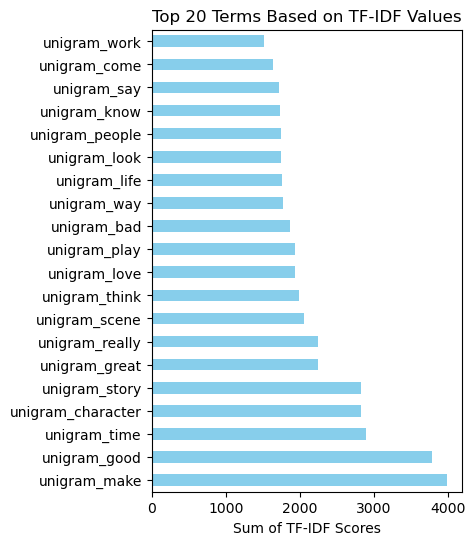

In [41]:
# Sum the TF-IDF scores for each term across all documents
sum_unigrams = train_unigram_df.sum(axis=0).sort_values(ascending=False)

# Select top N terms
top_n = 20
top_n_tfidf = sum_unigrams.nlargest(top_n)

# Plotting the top N terms
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 6))
top_n_tfidf.plot(kind='barh', color='skyblue')
plt.xlabel('Sum of TF-IDF Scores')
plt.title(f'Top {top_n} Terms Based on TF-IDF Values')
plt.show()

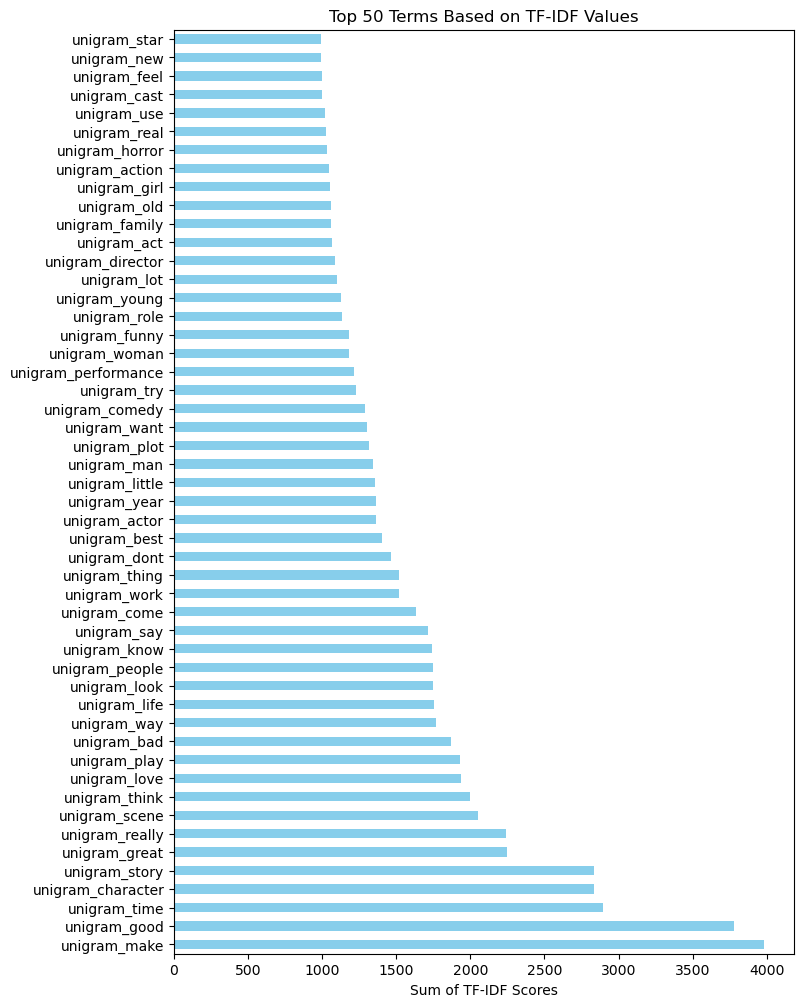

In [39]:
# Sum the TF-IDF scores for each term across all documents
sum_unigrams = train_unigram_df.sum(axis=0).sort_values(ascending=False)

# Select top N terms
top_n = 50
top_n_tfidf = sum_unigrams.nlargest(top_n)

# Plotting the top N terms
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
top_n_tfidf.plot(kind='barh', color='skyblue')
plt.xlabel('Sum of TF-IDF Scores')
plt.title(f'Top {top_n} Terms Based on TF-IDF Values')
plt.show()

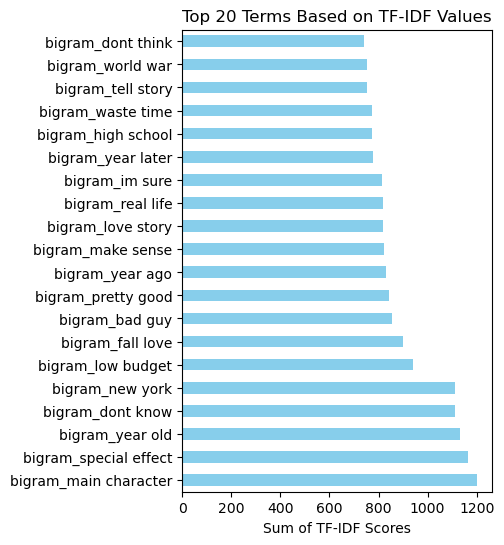

In [33]:
# Sum the TF-IDF scores for each term across all documents
sum_bigrams = train_bigram_df.sum(axis=0).sort_values(ascending=False)

# Select top N terms
top_n = 20
top_n_tfidf = sum_bigrams.nlargest(top_n)

# Plotting the top N terms
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 6))
top_n_tfidf.plot(kind='barh', color='skyblue')
plt.xlabel('Sum of TF-IDF Scores')
plt.title(f'Top {top_n} Terms Based on TF-IDF Values')
plt.show()

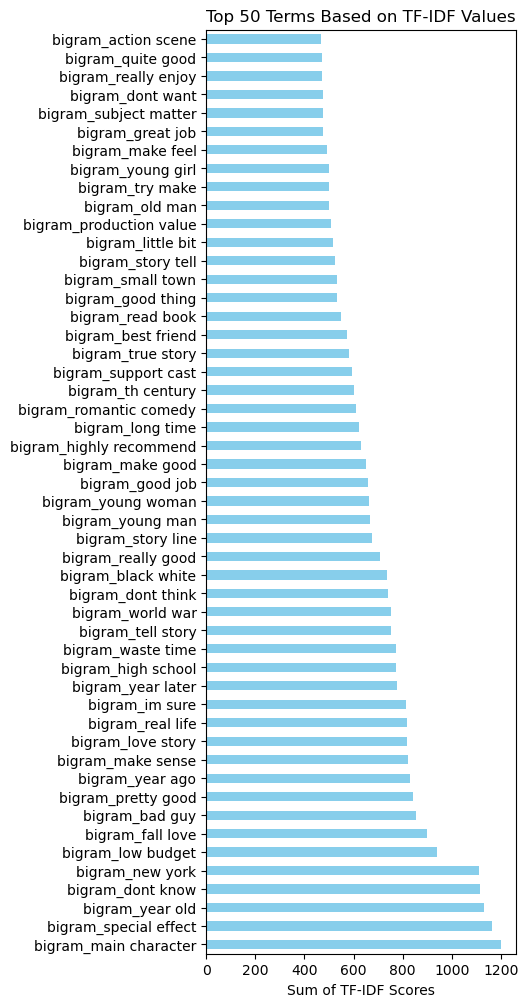

In [36]:
# Sum the TF-IDF scores for each term across all documents
sum_bigrams = train_bigram_df.sum(axis=0).sort_values(ascending=False)

# Select top N terms
top_n = 50
top_n_tfidf = sum_bigrams.nlargest(top_n)

# Plotting the top N terms
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 12))
top_n_tfidf.plot(kind='barh', color='skyblue')
plt.xlabel('Sum of TF-IDF Scores')
plt.title(f'Top {top_n} Terms Based on TF-IDF Values')
plt.show()

---

### Saving all the files 
(Please disregard this section; it is messy and doesn't make sense after several rounds of revisions, but didn't want to change it and risk losing track of something!)

Proceed to Final Dataframes section below :) 

In [149]:
## SAVING NEW DF with imdb ids and bigrams, unigrams, etc.
X_train_df_with_ngrams = pd.concat([train_final_df, train_unigram_df, train_bigram_df], axis=1)

In [151]:
X_test_df_with_ngrams = pd.concat([test_final_df, test_unigram_df, test_bigram_df], axis=1)

In [153]:
X_train_df_with_ngrams.to_csv('data/X_train_df_with_ngrams.csv', index=False)

In [152]:
X_test_df_with_ngrams.to_csv('data/X_test_df_with_ngrams.csv', index=False)

In [142]:
X_train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Columns: 2035 entries, language_en to bigram_youre look
dtypes: float64(2011), int64(24)
memory usage: 474.3 MB


In [65]:
X_test_final_df.head()

,language_en,runtime,budget,box_office_gross,votes,review_count,years_since_release,directors_max_score,actors_avg_score,production_companies_max_score,...,bigram_youll probably,bigram_young actor,bigram_young boy,bigram_young child,bigram_young girl,bigram_young man,bigram_young people,bigram_young woman,bigram_youre fan,bigram_youre look
0,1,-0.141276,-0.178912,-0.226741,-0.250093,-0.300626,1.293697,0.910534,0.514926,0.681250,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,1,-0.723412,-0.191943,-0.274226,-0.231332,-0.119911,1.089765,-0.851891,-1.373574,-1.819849,...,0.0,0.0,0.0,0.08408,0.0,0.032000,0.0,0.031747,0.000000,0.000000
2,1,-0.412939,0.186928,-0.153665,0.222795,0.201360,-0.256188,0.616797,-0.429324,0.806305,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.021743,0.026158,0.023409
3,1,0.596095,-0.159929,-0.300665,-0.252915,-0.280546,1.293697,0.690231,-0.429324,0.350306,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,1,-1.150311,-0.187705,-0.372021,-0.254293,-0.288578,1.783135,0.469928,-0.429324,0.350306,...,0.0,0.0,0.0,0.00000,0.0,0.133787,0.0,0.265461,0.159683,0.000000


In [105]:
X_train_final_df.to_json('data/X_train_final_df.json', orient='records', lines=True)

In [106]:
X_test_final_df.to_json('data/X_test_final_df.json', orient='records', lines=True)

In [108]:
final_processed_train_data = pd.concat([train_final_df, train_unigram_df, train_bigram_df], axis=1)

In [111]:
final_processed_test_data = pd.concat([test_final_df, test_unigram_df, test_bigram_df], axis=1)

In [112]:
final_processed_train_data.to_json('data/final_processed_train_data.json', orient='records', lines=True)

In [113]:
final_processed_test_data.to_json('data/final_processed_test_data.json', orient='records', lines=True)

In [320]:
new_train = final_processed_train_data.drop(columns=['directors_max_score', 'actors_avg_score', 'production_companies_max_score'])

In [321]:
new_test = final_processed_test_data.drop(columns=['directors_max_score', 'actors_avg_score', 'production_companies_max_score'])

In [322]:
# Select the columns we want from train
selected_columns = train_final_df[['imdb_id', 'actors_score', 'directors_score', 'producers_score']]

# Merge new train dataframe with the selected columns based on the imdb_id
new_train = pd.merge(new_train, selected_columns, on='imdb_id', how='left')

# Reorder columns to move these to the front
column_order = ['imdb_id', 'actors_score', 'directors_score', 'producers_score'] + [col for col in new_train.columns if col not in ['imdb_id', 'actors_score', 'directors_score', 'producers_score']]
new_train = new_train[column_order]

In [323]:
# Select the columns we want from test
selected_columns = test_final_df[['imdb_id', 'actors_score', 'directors_score', 'producers_score']]

# Merge new test with the selected columns based on the imdb_id
new_test = pd.merge(new_test, selected_columns, on='imdb_id', how='left')

# Reorder columns to move these to the front
column_order = ['imdb_id', 'actors_score', 'directors_score', 'producers_score'] + [col for col in new_test.columns if col not in ['imdb_id', 'actors_score', 'directors_score', 'producers_score']]
new_test = new_test[column_order]

In [325]:
new_train.head()

,imdb_id,actors_score,directors_score,producers_score,rating_category,language_en,runtime,budget,box_office_gross,votes,...,bigram_youll probably,bigram_young actor,bigram_young boy,bigram_young child,bigram_young girl,bigram_young man,bigram_young people,bigram_young woman,bigram_youre fan,bigram_youre look
0,tt0062480,-0.729363,0.641532,-0.499056,Good,0,0.246814,-0.189800,-0.235621,-0.090130,...,0.000000,0.0,0.000000,0.0,0.0,0.086723,0.0,0.0,0.0,0.030876
1,tt0282659,-0.247182,0.776527,-0.216355,Average,1,-0.141276,-0.105998,-0.343326,-0.250771,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,tt0273048,-0.449990,-0.568413,-0.493192,Average,1,0.440859,-0.161827,-0.374109,-0.255562,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,tt1630027,0.699220,-0.160521,-0.456419,Excellent,0,0.091578,-0.140771,-0.119638,-0.180553,...,0.000000,0.0,0.189996,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,tt0899106,3.359531,-0.450747,0.854090,Average,1,0.402050,0.034971,0.374944,0.109804,...,0.028498,0.0,0.000000,0.0,0.0,0.022325,0.0,0.0,0.0,0.023845


In [331]:
new_test.head()

,imdb_id,actors_score,directors_score,producers_score,rating_category,language_en,runtime,budget,box_office_gross,votes,...,bigram_youll probably,bigram_young actor,bigram_young boy,bigram_young child,bigram_young girl,bigram_young man,bigram_young people,bigram_young woman,bigram_youre fan,bigram_youre look
0,tt0050405,-0.738285,-0.662084,-0.499297,Good,1,-0.141276,-0.178912,-0.226741,-0.250093,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,tt0056211,-0.737372,-0.379126,-0.499132,Poor,1,-0.723412,-0.191943,-0.274226,-0.231332,...,0.0,0.0,0.0,0.08408,0.0,0.032000,0.0,0.031747,0.000000,0.000000
2,tt0112896,-0.524648,-0.430117,0.819429,Average,1,-0.412939,0.186928,-0.153665,0.222795,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.021743,0.026158,0.023409
3,tt0051066,-0.739040,-0.640143,0.560420,Average,1,0.596095,-0.159929,-0.300665,-0.252915,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,tt0037776,-0.741753,-0.664348,0.560420,Average,1,-1.150311,-0.187705,-0.372021,-0.254293,...,0.0,0.0,0.0,0.00000,0.0,0.133787,0.0,0.265461,0.159683,0.000000


## Final Dataframes

Now, we are saving our final combinbed dataframes with the new feature engineering we've complete in this notebook as well as the vectorized ngrams to files. We will also prepare the target variables for modeling, and drop the unneeded columns from the train and test data.

In [327]:
new_train.to_csv('data/new_train_final.csv', index=False)

In [328]:
new_test.to_csv('data/new_test_final.csv', index=False)

In [243]:
new_train = new_train.drop(columns=['rating_category', 'imdb_id'])

In [248]:
new_train = new_train.drop(columns=['cleaned_review'])

In [249]:
new_train.head()

,actors_score,directors_score,producers_score,language_en,runtime,budget,box_office_gross,votes,review_count,years_since_release,...,bigram_youll probably,bigram_young actor,bigram_young boy,bigram_young child,bigram_young girl,bigram_young man,bigram_young people,bigram_young woman,bigram_youre fan,bigram_youre look
0,-0.729363,0.641532,-0.499056,0,0.246814,-0.189800,-0.235621,-0.090130,0.072851,0.885833,...,0.000000,0.0,0.000000,0.0,0.0,0.086723,0.0,0.0,0.0,0.030876
1,-0.247182,0.776527,-0.216355,1,-0.141276,-0.105998,-0.343326,-0.250771,-0.280546,-0.541694,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,-0.449990,-0.568413,-0.493192,1,0.440859,-0.161827,-0.374109,-0.255562,-0.304641,-0.500907,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.699220,-0.160521,-0.456419,0,0.091578,-0.140771,-0.119638,-0.180553,-0.284562,-0.908772,...,0.000000,0.0,0.189996,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,3.359531,-0.450747,0.854090,1,0.402050,0.034971,0.374944,0.109804,-0.015498,-0.827199,...,0.028498,0.0,0.000000,0.0,0.0,0.022325,0.0,0.0,0.0,0.023845


In [ ]:
new_test = new_test.drop(columns=['rating_category', 'imdb_id'])

In [254]:
new_test = new_test.drop(columns=['cleaned_review'])

In [255]:
new_test.head()

,actors_score,directors_score,producers_score,language_en,runtime,budget,box_office_gross,votes,review_count,years_since_release,...,bigram_youll probably,bigram_young actor,bigram_young boy,bigram_young child,bigram_young girl,bigram_young man,bigram_young people,bigram_young woman,bigram_youre fan,bigram_youre look
0,-0.738285,-0.662084,-0.499297,1,-0.141276,-0.178912,-0.226741,-0.250093,-0.300626,1.293697,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,-0.737372,-0.379126,-0.499132,1,-0.723412,-0.191943,-0.274226,-0.231332,-0.119911,1.089765,...,0.0,0.0,0.0,0.08408,0.0,0.032000,0.0,0.031747,0.000000,0.000000
2,-0.524648,-0.430117,0.819429,1,-0.412939,0.186928,-0.153665,0.222795,0.201360,-0.256188,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.021743,0.026158,0.023409
3,-0.739040,-0.640143,0.560420,1,0.596095,-0.159929,-0.300665,-0.252915,-0.280546,1.293697,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,-0.741753,-0.664348,0.560420,1,-1.150311,-0.187705,-0.372021,-0.254293,-0.288578,1.783135,...,0.0,0.0,0.0,0.00000,0.0,0.133787,0.0,0.265461,0.159683,0.000000


In [257]:
new_test.to_csv('data/new_test_with_new_actor_score.csv', index=False)

In [258]:
new_train.to_csv('data/new_train_with_new_actor_score.csv', index=False)

Saving our X variables as a copy of the final dataframes we created after dropping all appropriate columns.

In [261]:
X_train = new_train.copy()

In [262]:
X_test = new_test.copy()

In [242]:
# Prepare target variables
y_train = train_final_df['rating_category'].values
y_test = test_final_df['rating_category'].values

Now that we have X_train, X_test, and our y_train and y_test, we are ready to move on to modeling.

### Baseline Models with text data

##### Logistic Regression

We'll first try a logistic regression model with C=0.5 (based on previous results)

In [266]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate and train the model
logreg_model = LogisticRegression(max_iter=1000, C=0.5)

logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_train = logreg_model.predict(X_train)
y_pred_test = logreg_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.7184288052373159
Test Accuracy: 0.6538763750654794


In [267]:
from sklearn.metrics import classification_report

# Generate and print the classification report for training data
print("Classification Report for Training Data:")
print(classification_report(y_train, y_pred_train))

# Generate and print the classification report for test data
print("Classification Report for Test Data:")
print(classification_report(y_test, y_pred_test))

Classification Report for Training Data:
              precision    recall  f1-score   support

     Average       0.63      0.62      0.63      7679
   Excellent       0.80      0.79      0.79      6939
        Good       0.63      0.66      0.64      8027
        Poor       0.82      0.82      0.82      7905

    accuracy                           0.72     30550
   macro avg       0.72      0.72      0.72     30550
weighted avg       0.72      0.72      0.72     30550

Classification Report for Test Data:
              precision    recall  f1-score   support

     Average       0.54      0.53      0.53      1899
   Excellent       0.76      0.74      0.75      1762
        Good       0.55      0.56      0.56      1980
        Poor       0.78      0.78      0.78      1995

    accuracy                           0.65      7636
   macro avg       0.66      0.65      0.66      7636
weighted avg       0.65      0.65      0.65      7636



It seems that adding our text data in has improved the scores somewhat from just the numerical data. But looking at the classifcation report, again, we see that the model is having trouble distinguishing between Average and Good movies from other classes.

##### Random Forest

Next we'll try a Random Forest model. 

In [268]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate 
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

print(f"Training Accuracy with Random Forest: {train_accuracy_rf}")
print(f"Test Accuracy with Random Forest: {test_accuracy_rf}")

Training Accuracy with Random Forest: 1.0
Test Accuracy with Random Forest: 0.6106600314300681


In [269]:
# Classification Report
print("\nClassification Report for Random Forest Training Data:")
print(classification_report(y_train, y_pred_train_rf))

print("\nClassification Report for Random Forest Test Data:")
print(classification_report(y_test, y_pred_test_rf))


Classification Report for Random Forest Training Data:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00      7679
   Excellent       1.00      1.00      1.00      6939
        Good       1.00      1.00      1.00      8027
        Poor       1.00      1.00      1.00      7905

    accuracy                           1.00     30550
   macro avg       1.00      1.00      1.00     30550
weighted avg       1.00      1.00      1.00     30550


Classification Report for Random Forest Test Data:
              precision    recall  f1-score   support

     Average       0.49      0.44      0.46      1899
   Excellent       0.71      0.69      0.70      1762
        Good       0.50      0.51      0.50      1980
        Poor       0.73      0.80      0.76      1995

    accuracy                           0.61      7636
   macro avg       0.61      0.61      0.61      7636
weighted avg       0.61      0.61      0.61      7636



Looking at the results, the Random Forest model seems to overfit the training data. We could try tuning the hyperparameters.  The logistic regression model still appears to be the better-performing model based on test accuracy and the F1-score.

##### XGBoost

Let's try XGBoost to compare. First we must label encode the target variable. We'll start with some basic hyperparameters. 

- https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9
- https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier

In [270]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform training data
y_train_encoded = le.fit_transform(y_train)

# Transform test data
y_test_encoded = le.transform(y_test)

In [271]:
from xgboost import XGBClassifier

# Instantiate model
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=4, 
    nthread=4,
    seed=42
)

# Fit the model
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# Evaluate the model
train_accuracy_xgb = accuracy_score(y_train_encoded, y_pred_train_xgb)
test_accuracy_xgb = accuracy_score(y_test_encoded, y_pred_test_xgb)

print(f"Training Accuracy with XGBoost: {train_accuracy_xgb}")
print(f"Test Accuracy with XGBoost: {test_accuracy_xgb}")

Training Accuracy with XGBoost: 0.8294271685761048
Test Accuracy with XGBoost: 0.6897590361445783


We see a large improvement training accuracy but also overfitting with XGBoost. The test score has only slightly improved from our previous highest score of 65% with logistic regression. Let's take a look at the classification report as well.

In [272]:
# Decode the predictions
y_pred_train_decoded = le.inverse_transform(y_pred_train_xgb)
y_pred_test_decoded = le.inverse_transform(y_pred_test_xgb)

# Classification report
print("Classification Report for XGBoost Training Data:")
print(classification_report(y_train, y_pred_train_decoded))

print("Classification Report for XGBoost Test Data:")
print(classification_report(y_test, y_pred_test_decoded))

Classification Report for XGBoost Training Data:
              precision    recall  f1-score   support

     Average       0.79      0.75      0.77      7679
   Excellent       0.89      0.88      0.88      6939
        Good       0.77      0.81      0.79      8027
        Poor       0.88      0.88      0.88      7905

    accuracy                           0.83     30550
   macro avg       0.83      0.83      0.83     30550
weighted avg       0.83      0.83      0.83     30550

Classification Report for XGBoost Test Data:
              precision    recall  f1-score   support

     Average       0.57      0.55      0.56      1899
   Excellent       0.81      0.81      0.81      1762
        Good       0.59      0.62      0.61      1980
        Poor       0.80      0.79      0.79      1995

    accuracy                           0.69      7636
   macro avg       0.69      0.69      0.69      7636
weighted avg       0.69      0.69      0.69      7636



##### SVM
Next we'll try a SVM model.

In [274]:
from sklearn.svm import LinearSVC

# Instantiate and fit
svc_model = LinearSVC(max_iter=100000, dual=True, random_state=42, C=0.5)
svc_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_train_svc = svc_model.predict(X_train)
y_pred_test_svc = svc_model.predict(X_test)

# Evaluate
train_accuracy_svc = accuracy_score(y_train_encoded, y_pred_train_svc)
test_accuracy_svc = accuracy_score(y_test_encoded, y_pred_test_svc)

print(f"Training Accuracy with LinearSVC: {train_accuracy_svc}")
print(f"Test Accuracy with LinearSVC: {test_accuracy_svc}")

Training Accuracy with LinearSVC: 0.711227495908347
Test Accuracy with LinearSVC: 0.6206128863279203


In [275]:
# Print Classification Report
print("Classification Report for SVC Training Data:")
print(classification_report(y_train_encoded, y_pred_train_svc))

print("Classification Report for SVC Test Data:")
print(classification_report(y_test_encoded, y_pred_test_svc))

Classification Report for SVC Training Data:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      7679
           1       0.76      0.85      0.80      6939
           2       0.64      0.58      0.61      8027
           3       0.79      0.86      0.82      7905

    accuracy                           0.71     30550
   macro avg       0.71      0.71      0.71     30550
weighted avg       0.70      0.71      0.71     30550

Classification Report for SVC Test Data:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47      1899
           1       0.70      0.79      0.74      1762
           2       0.52      0.45      0.48      1980
           3       0.72      0.81      0.76      1995

    accuracy                           0.62      7636
   macro avg       0.61      0.62      0.61      7636
weighted avg       0.61      0.62      0.61      7636



We got reasonably good accuracy with this model. The precision, recall, and F1-scores are not as high as in the other models, but they still show reasonable performance across classes. 

#### Feature Importance
Let's take a look at the feature importance scores from our Random Forest model.

In [276]:
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

In [277]:
# Create a DataFrame for the top 50 features
top_50_features = pd.DataFrame({
    'Feature': names[:50],
    'Importance': importances[indices][:50]
})

In [278]:
top_50_features 

,Feature,Importance
0,unigram_bad,0.016822
1,unigram_awful,0.007219
2,votes,0.005975
3,unigram_budget,0.005726
4,unigram_waste,0.005682
5,scaled_avg_sentiment_score,0.005640
6,unigram_terrible,0.005499
7,unigram_pretty,0.005205
8,unigram_horrible,0.005037
9,unigram_decent,0.004960


Analyzing feature importances help us to understand which variables are driving the model's predictions. 

1. **Sentiment-Related Features**: The highest-ranking features seem to relate to the sentiment of the movie, like 'unigram_bad', 'unigram_awful', 'unigram_terrible', etc. This indicates that the sentiment surrounding a movie is a strong predictor of its rating category.

2. **Votes and Budget**: 'votes' and 'budget' are also high on the list, which could suggest that these features often associated with the scale or popularity of a movie have an impact on its rating.

3. **Runtime and Language**: These appear lower down but still have significance. This could indicate that longer movies or movies in certain languages may generally receive different ratings.

4. **Entity Scores**: Features like 'actors_score' and 'producers_score' show up but are not among the top-most features. They still contribute to the model but are not the most defining features.

5. **Time-Related**: 'years_since_release' appears in the list, which could indicate that newer or older movies may have some consistent trends in ratings.

6. **Genre-Specific**: 'genre_Documentary' shows up, indicating that perhaps documentaries have a particular kind of rating distribution different from other genres.

Of course, feature importance does not imply causality, it only shows us which features are most predictive according to the model.

We can also look at a correlation matrix for the most important features, to see if any are highly correlated with each other and may not be providing any additional information to the model. 

In [279]:
# Get correlation matrix
corr = X_train.corr()

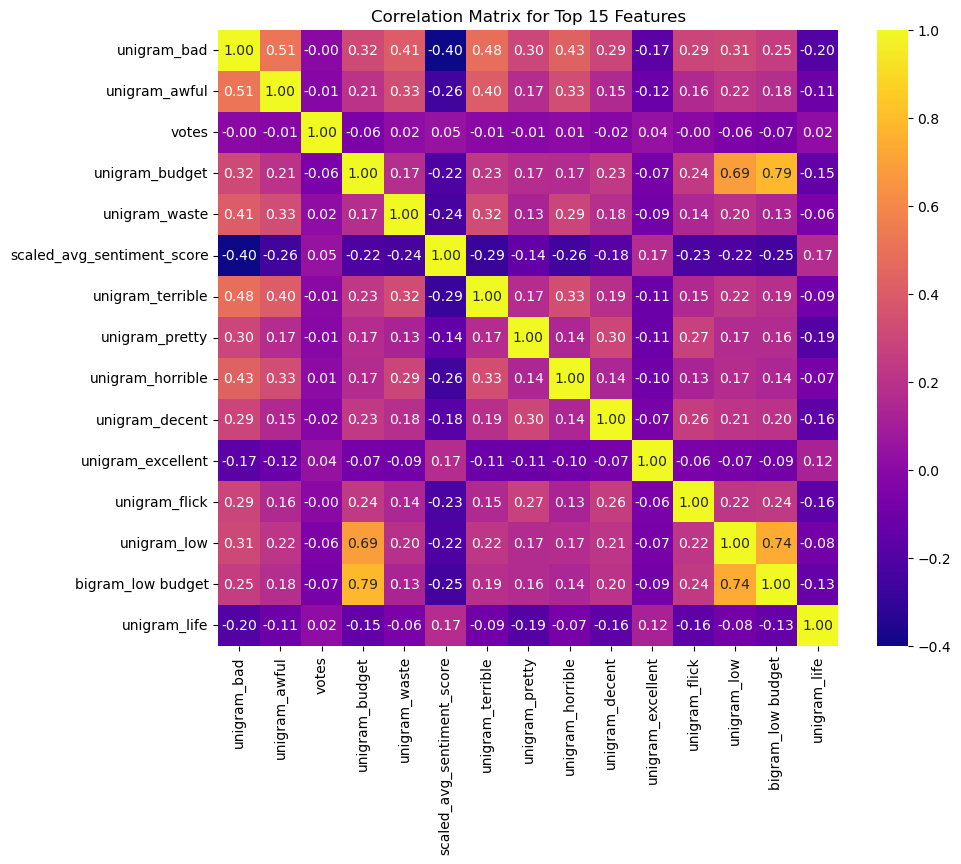

In [284]:
# Get top 15 most important features based on previous importance dataframe
top_15_features = top_50_features['Feature'][:15]

# Compute the correlation matrix for the top 15 features
corr_top_15 = X_train[top_15_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_top_15, annot=True, cmap='plasma', fmt='0.2f')

plt.title('Correlation Matrix for Top 15 Features')
plt.show()

We can see that the highest correlations are between unigram_low, unigram_budget, and unigram_low_budget. This makes sense, as they are capturing the same type of sentiment regarding low budget from the user reviews. Additionally, there are other similar unigrams/synonyms that have somewhat high correlations, but not overly high such that we are worried about multicollinearity.

---

### Further Model Interpretation

Now that we've tried a few baseline models and looked at some feature importance scores, let's see if there is anything else we can learn about the features and how they're affecting our model. We will use SHAP to see if we can get a better understanding of how each feature is contributing to the prediction for individual data points in the context of the model.  

We will train our model, create a SHAP explainer based on that model, calculate SHAP values for the data, and then plot those values to understand how each feature is influencing the model's predictions. We'll try it on a Random Forest model first.

In [281]:
# First import library 
import shap

In [285]:
import shap

# Initialize RandomForest model
shap_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
shap_rf_model.fit(X_train, y_train)

# Create a SHAP explainer object
explainer = shap.TreeExplainer(shap_rf_model)

# Compute SHAP values for a set of samples of the dataset
shap_values = explainer.shap_values(X_test.iloc[:100, :])

# Plot the SHAP values for the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

This visualization indicates that the feature `votes` has a significant negative contribution to the prediction. This means that, for this particular instance, the value of votes is pushing the model's prediction to be lower than the base value by approximately 0.2501. The base value represents the average prediction of the model across the entire dataset. 

We can also look at a SHAP summary plot.

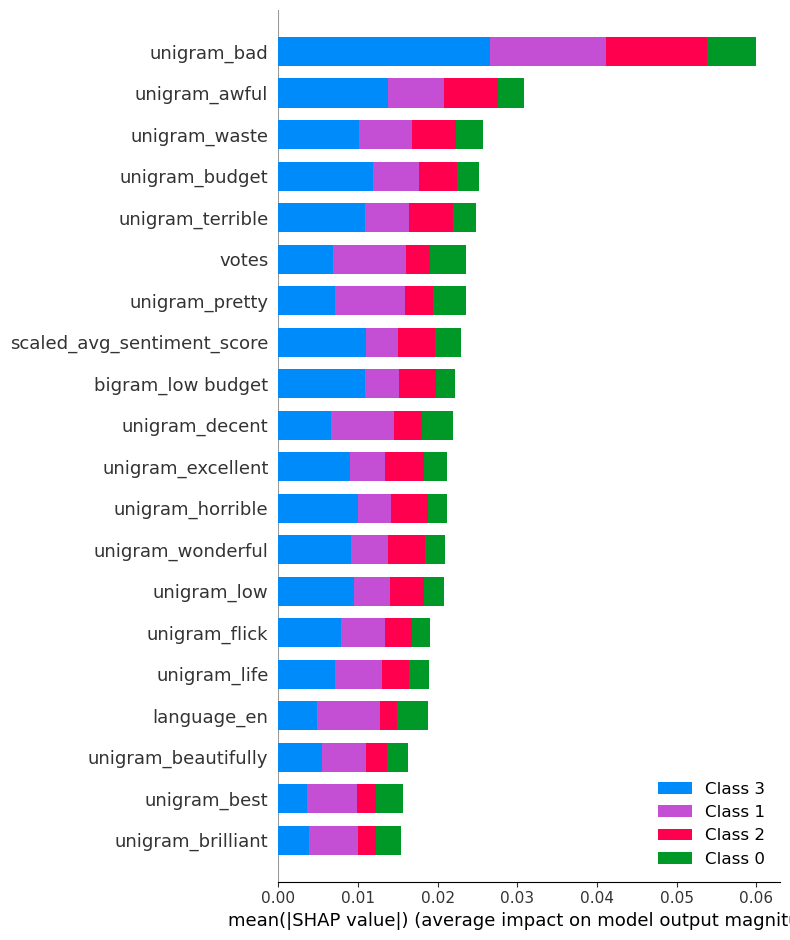

In [333]:
# Summary plot
shap.summary_plot(shap_values, X_test.iloc[:100, :])

We need to see how the model classified our `rating_category` since we didn't use encoded data.

In [334]:
# Print out the mapping used by the model
for class_num, class_name in enumerate(shap_rf_model.classes_):
    print(f"Class {class_num}: {class_name}")

Class 0: Average
Class 1: Excellent
Class 2: Good
Class 3: Poor


**SHAP Values for Model Predictions**

The SHAP summary plot provides insights into the impact of each feature on the model's predictions. Each row in the plot corresponds to a feature, and the x-axis represents the average magnitude of the SHAP value for that feature. The color coding of the bars corresponds to the classes: Average, Excellent, Good, and Poor.

1. **Key Observations:**
    - The feature `unigram_bad` has the most substantial impact on the model's predictions. It heavily leans towards predicting the class "Poor" when present.
    - Features like `unigram_awful`, `unigram_waste`, and `unigram_terrible` also show strong influences towards the "Poor" class.
    - The feature `votes` has a diverse impact, influencing predictions for all classes, with a notable effect on the "Excellent" class.
    - The `scaled_avg_sentiment_score` seems to influence both the "Excellent" and "Good" classes.
    - Positive words like `unigram_excellent`, `unigram_wonderful`, and `unigram_brilliant` influence predictions towards the "Excellent" class.
<br><br>
2. **Insights about Specific Classes:**
    - **Average**: Features like `unigram_flick`, `unigram_life`, and `language_en` seem to moderately influence predictions towards the "Average" class.
    - **Excellent**: As mentioned, features like `votes`, `unigram_excellent`, and `unigram_wonderful` push the predictions towards this class.
    - **Good**: The `scaled_avg_sentiment_score` and `unigram_pretty` appear to be influential in determining the "Good" class.
    - **Poor**: Negative sentiment words, including `unigram_bad`, `unigram_awful`, and `unigram_terrible`, strongly sway predictions towards the "Poor" class.
<br><br>
3. **Conclusion:**
    - Sentiment-related unigrams play a vital role in classifying movie reviews. Negative sentiments tend to push predictions towards the "Poor" class, while positive sentiments influence the "Excellent" class, as would be expected.
    - Some features have diverse impacts across multiple classes, indicating the complexity of the decision boundaries in the model.

By understanding the impact of each feature on the predictions, we can better interpret the model's decisions and potentially identify areas for improvement.

---

#### Feature Selection

Since we have a large amount of features and are seeing overfitting in most of our models, we should consider if there are any features we can drop to help reduce overfitting and noise in the data. We can use sklearn VarianceThreshold class to remove features with low variance. We'll run `fit_transform` on the entire `X_train` dataframe and then fit it to our `X_test` data. Then we can re-run our models with the reduced dataframe to see how the accuracy changes.

In [313]:
from sklearn.feature_selection import VarianceThreshold

# Initialize the VarianceThreshold object
selector = VarianceThreshold(threshold=0.0005)

# Fit the VarianceThreshold object to X_train 
selector.fit(X_train)

# Transform the data
X_train_reduced = selector.transform(X_train)

# Convert back to dataframe
selected_columns = X_train.columns[selector.get_support()]
X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_columns)

In [337]:
X_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30550 entries, 0 to 30549
Columns: 1102 entries, actors_score to bigram_youre look
dtypes: float64(1102)
memory usage: 256.9 MB


After performing feature selection, our columns have decreased from 2038 to 1102, using a threshold of 0.0005. We can now fit our test data and then re-run models to see how the scores have changed.

In [315]:
# Transform the test data 
X_test_reduced = selector.transform(X_test)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_columns)

Let's run logistic regression again. 

In [316]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate and train the model
logreg_model = LogisticRegression(max_iter=1000, C=0.5)

logreg_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred_train = logreg_model.predict(X_train_reduced)
y_pred_test = logreg_model.predict(X_test_reduced)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.6826513911620294
Test Accuracy: 0.641566265060241


Previous Logistic Regression Results: 
- Training Accuracy: 0.7184288052373159
- Test Accuracy: 0.6538763750654794

Now let's try XGBoost again. 

In [335]:
from xgboost import XGBClassifier

# Instantiate model
xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=4, 
    nthread=4,
    seed=42
)

# Fit the model
xgb_model.fit(X_train_reduced, y_train_encoded)

# Make predictions
y_pred_train_xgb = xgb_model.predict(X_train_reduced)
y_pred_test_xgb = xgb_model.predict(X_test_reduced)

# Evaluate the model
train_accuracy_xgb = accuracy_score(y_train_encoded, y_pred_train_xgb)
test_accuracy_xgb = accuracy_score(y_test_encoded, y_pred_test_xgb)

print(f"Training Accuracy with XGBoost: {train_accuracy_xgb}")
print(f"Test Accuracy with XGBoost: {test_accuracy_xgb}")

Training Accuracy with XGBoost: 0.8086415711947627
Test Accuracy with XGBoost: 0.6829491880565741


Previous results with full dataframe: 
- Training Accuracy with XGBoost: 0.8294271685761048
- Test Accuracy with XGBoost: 0.6897590361445783

In [336]:
# Decode the predictions
y_pred_train_decoded = le.inverse_transform(y_pred_train_xgb)
y_pred_test_decoded = le.inverse_transform(y_pred_test_xgb)

# Classification report
print("Classification Report for XGBoost Training Data:")
print(classification_report(y_train, y_pred_train_decoded))

print("Classification Report for XGBoost Test Data:")
print(classification_report(y_test, y_pred_test_decoded))

Classification Report for XGBoost Training Data:
              precision    recall  f1-score   support

     Average       0.76      0.73      0.74      7679
   Excellent       0.87      0.87      0.87      6939
        Good       0.75      0.78      0.76      8027
        Poor       0.86      0.86      0.86      7905

    accuracy                           0.81     30550
   macro avg       0.81      0.81      0.81     30550
weighted avg       0.81      0.81      0.81     30550

Classification Report for XGBoost Test Data:
              precision    recall  f1-score   support

     Average       0.57      0.53      0.55      1899
   Excellent       0.80      0.80      0.80      1762
        Good       0.58      0.62      0.60      1980
        Poor       0.79      0.79      0.79      1995

    accuracy                           0.68      7636
   macro avg       0.69      0.68      0.68      7636
weighted avg       0.68      0.68      0.68      7636



In [338]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train_reduced)
y_pred_test_rf = rf_model.predict(X_test_reduced)

# Evaluate 
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

print(f"Training Accuracy with Random Forest: {train_accuracy_rf}")
print(f"Test Accuracy with Random Forest: {test_accuracy_rf}")

Training Accuracy with Random Forest: 1.0
Test Accuracy with Random Forest: 0.6178627553693034


Let's compare our models' performance before and after feature selection: 

#### Logistic Regression
- **Before**: Training accuracy was approximately 71.8% and test accuracy was about 65.4%.
- **After**: Training accuracy dropped to 68.3%, but test accuracy slightly decreased to 64.2%.

#### XGBoost
- **Before**: Training accuracy was high at 82.9% with test accuracy at 69.0%.
- **After**: Training accuracy dropped to 80.9%, but the test accuracy slightly decreased to 68.3%.

#### Random Forest
- **Before**: Overfitting was obvious here with 100% training accuracy and 61.1% test accuracy.
- **After**: Still overfitting with 100% training accuracy, but test accuracy slightly improved to 61.8%.


#### Observations
1. **Overfitting in Random Forest**: The Random Forest model shows a clear sign of overfitting both before and after feature selection. This needs to be addressed, perhaps by tuning hyperparameters like tree depth, minimum samples at leaf, etc.

2. **Mild Changes in XGBoost and Logistic Regression**: For both Logistic Regression and XGBoost, the training accuracy dropped a bit, but the test accuracy remained roughly the same or even slightly improved (in the case of Random Forest). This suggests that the feature selection may have removed some noise or irrelevant features, which is good for model generalization.

3. **Consistency in Test Accuracy**: The test accuracy for Logistic Regression and XGBoost didn't change much, meaning the features removed probably weren't carrying much predictive power. 

4. **Drop in Training Accuracy**: The drop in training accuracy for Logistic Regression and XGBoost is expected as the models had fewer features to "learn" from. But since test accuracy didn't decline significantly, this should generally be a good trade-off.

Overall, feature selection seems to have had a generally positive or neutral effect on model performance in terms of test accuracy, but further tuning is needed, especially for the Random Forest model.

### Next Steps 
Next, we will move into the final modeling stage, tuning hyperparameteres and using GridSearch and crossvalidation to validate our model scores and do further model interpretation. 